<h1>Bank Marketing Dataset (bank-additional-full)</h1>

<b>Topic</b>: Direct marketing campaigns of a bank to make clients subscribe a bank term deposit.<br>

PRIVACY LIMTATION: This dataset is almost identical to the one used in [Moro et al., 2014] (it does not include all attributes due to privacy concerns). <br>
DATASET: bank-additional-full.csv with all examples, ordered by date (from May 2008 to November 2010).



In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math 
import time
import seaborn as sns
import datetime

from sklearn import preprocessing
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate, selection_rate, equalized_odds_difference, demographic_parity_difference, selection_rate
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer

In [2]:
bankdf = pd.read_csv("bank-additional-full.csv", sep=";")
bankdf.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<h1>FEATURE ENGINEERING</h1>

- Year: does it make sense to derive a year column to complete the date? Can be derived knowing that data are ordered. 
- Education: just one big basic class instead of all years?
- Duration: in minutes instead of seconds?


In [3]:
# CREATION OF YEAR VARIABLE

nemployed = bankdf['nr.employed']

unique, index = np.unique(nemployed, return_index=True) # [5191. , 5228.1, 5195.8, 5176.3, 5099.1, 5076.2, 5017.5, 5023.5, 5008.7, 4991.6, 4963.6]

# 2008: 5191. , 5228.1, 5195.8
# 2009: 5176.3, 5099.1, 5076.2, 5017.5
# 2010: 5023.5, 5008.7, 4991.6, 4963.6

year_df = {'year':['2008','2008','2008','2009','2009','2009','2009','2010','2010','2010','2010'], 
           'nr.employed':[5191. , 5228.1, 5195.8, 5176.3, 5099.1, 5076.2, 5017.5, 5023.5, 5008.7, 4991.6, 4963.6]}
year_df = pd.DataFrame.from_dict(year_df)

bankdf = bankdf.merge(year_df, on='nr.employed', how='left')

In [4]:
# Creating a function to convert the month abbrevuation in number

bankdf["month_name"] = bankdf["month"]

def convert_month(df):
    df['month'] = [int(datetime.datetime.strptime(obv, '%b').month) for obv in df['month_name']]
    df['year'] = [int(obv) for obv in df['year']]
convert_month(bankdf)




<h1>DESCRIPTION OF DATASET, CORRELATION MATRIX, PAIRPLOT and DESCRIPTION OF CATEGORICAL VARS</h1>

1) Describe() is used to provide descriptive statistics of the numerical variables in the dataset<br>
2) Correlation Heatmap: correlation of the numerical variables. Orange means positive correlation, Blue means negative correlation.<br>
3) PairPLot: scatterplots of the pairs of numerical variables, in the diagonal there is a KDE.<br>
4) Categorical Variables Description

A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.

In [5]:
#bankdf.info() # 41188  rows × 21 columns, 20 features and 1 target variable
bankdf.describe()  # statistics of numerical data

,age,month,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,year
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,6.607896,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,2008.382102
std,10.42125,2.040998,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.586849
min,17.00000,3.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,2008.000000
25%,32.00000,5.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,2008.000000
50%,38.00000,6.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,2008.000000
75%,47.00000,8.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,2009.000000
max,98.00000,12.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,2010.000000


In [6]:
# Description of Categorical Variables
bankdf.describe(include=['object']) # categorical variables

,job,marital,education,default,housing,loan,contact,day_of_week,poutcome,y,month_name
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,5,3,2,10
top,admin.,married,university.degree,no,yes,no,cellular,thu,nonexistent,no,may
freq,10422,24928,12168,32588,21576,33950,26144,8623,35563,36548,13769


Text(0.5, 1.0, 'Correlation Heatmap')

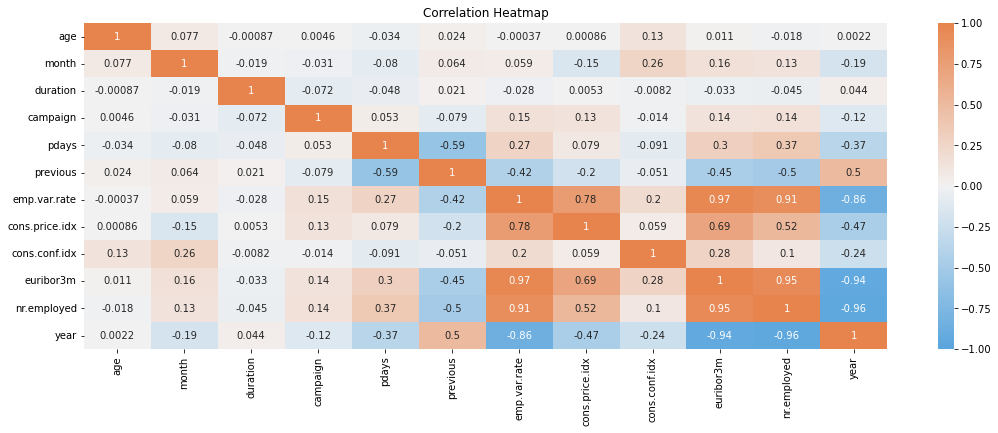

In [7]:
plt.figure(figsize=(18, 6))

pal2 = sns.diverging_palette(240, 30, l=65, as_cmap=True)

heatmap = sns.heatmap(bankdf.corr(), vmin=-1, vmax=1, annot=True,cmap=pal2)
heatmap.set_title('Correlation Heatmap')

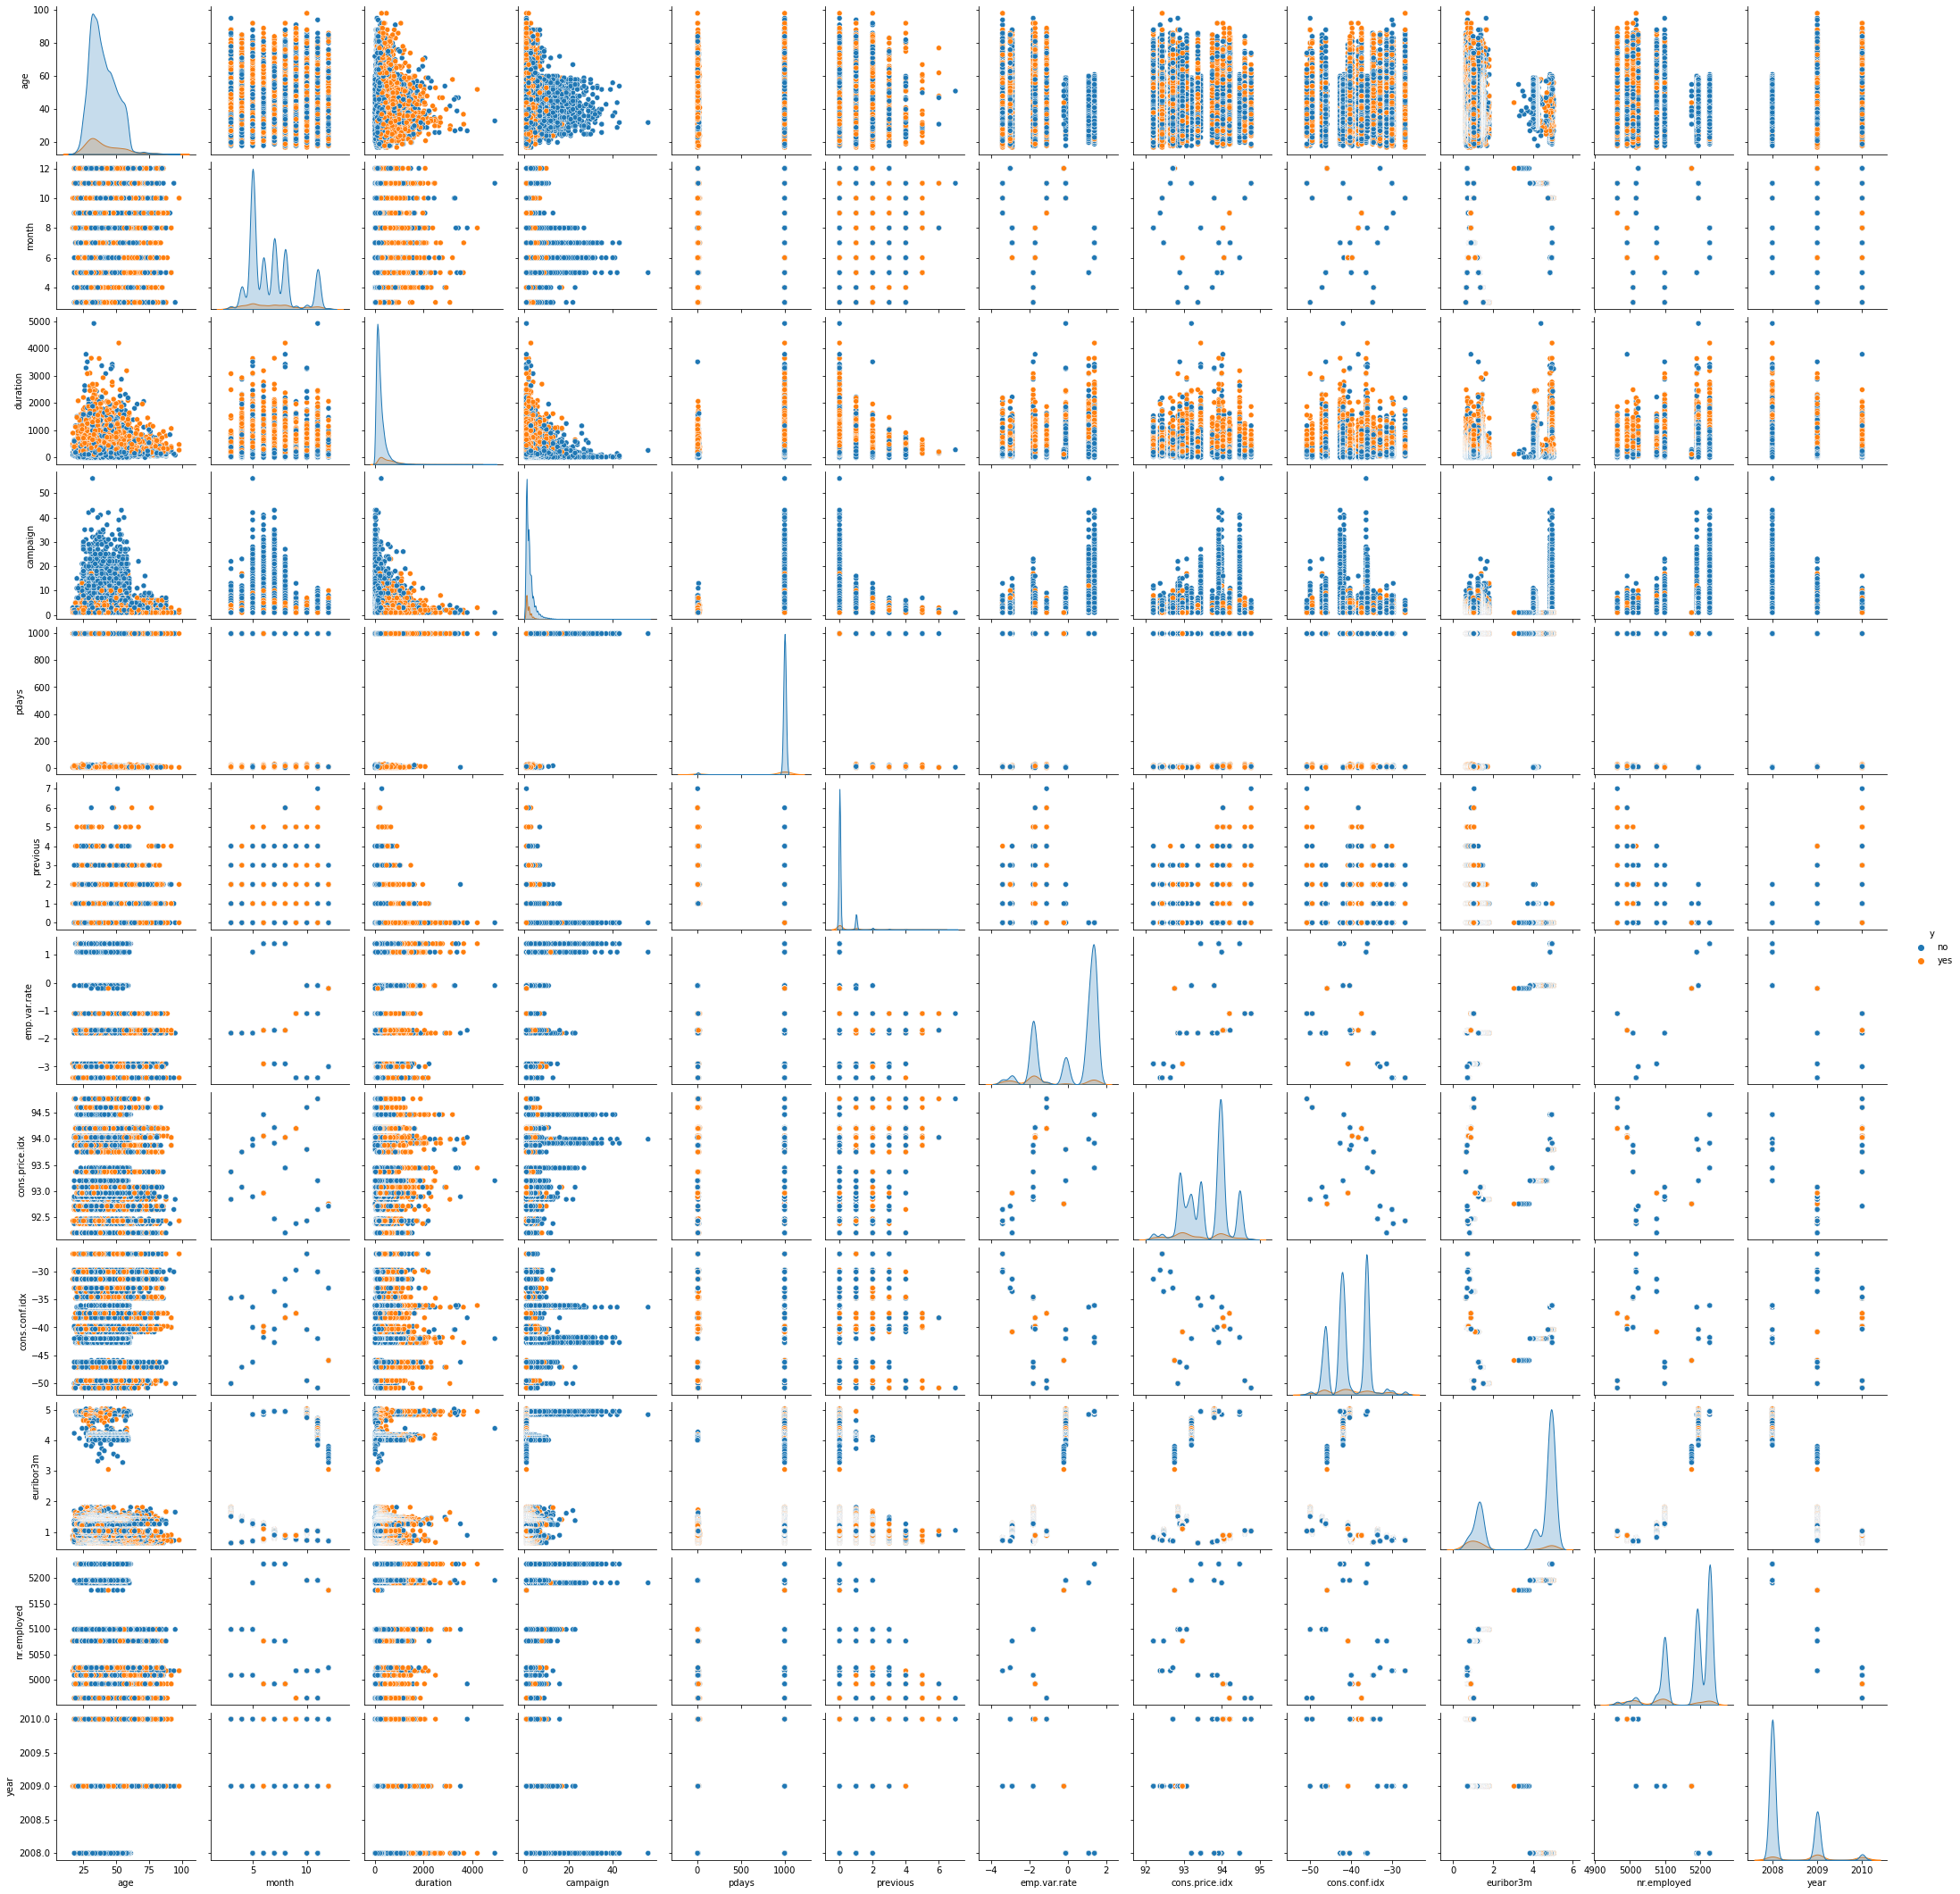

In [8]:
# ATTENTION TO THIS!!! TAKES A LOT OF TIME!!!

# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166

sns.pairplot(bankdf, hue="y", diag_kind = 'kde')

<h1>VISUALIZATION: Numerical variables</h1>

<AxesSubplot:xlabel='Date'>

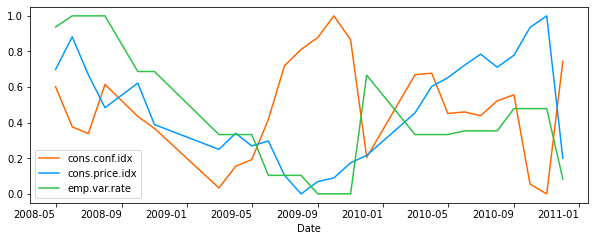

In [9]:
# FLUCTUATIONS OF 3 ECONOMIC FEATURES; STANDARDIZED
pal = [ "#ff6600", "#0099ff", "#2BC344"]
sns.set_palette(pal)

bankdf["day"] = int(1)
bankdf['date']=pd.to_datetime(bankdf[['year','month','day']])

scaler = preprocessing.MinMaxScaler()
dfp = pd.pivot_table(data=bankdf, index='date', values=["cons.price.idx", "emp.var.rate","cons.conf.idx"], 
                     aggfunc='first')

dfp[:] = scaler.fit_transform(dfp)

dfp.plot(figsize=(10, 4), ylabel='', xlabel='Date', rot=0) #with standardized data. looking at fluctuations over time



<AxesSubplot:xlabel='age', ylabel='Density'>

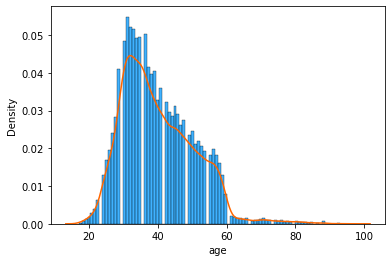

In [10]:
# Age

ax = sns.histplot(data=bankdf, x="age", kde=False, stat='density', color="#0099ff")
sns.kdeplot(data=bankdf, x="age", color="#ff6600", ax=ax)

<AxesSubplot:xlabel='duration', ylabel='Density'>

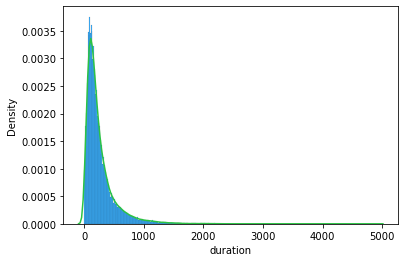

In [11]:
# Duration

ax = sns.histplot(bankdf["duration"], kde=False, stat='density', color="#0099ff")
sns.kdeplot(bankdf["duration"], color="#2BC344", ax=ax)

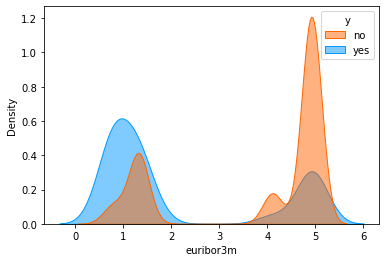

In [12]:
# Density plot with euribor3m and y outcome. Interesting.


sns.kdeplot(data=bankdf, x="euribor3m", hue="y", fill=True, common_norm=False, alpha=.5)
plt.show()

In [13]:
# VISUALIZATION: y and DURATION

sns.kdeplot(data=bankdf, x="duration", hue="y", fill=True, common_norm=False, palette=pal, alpha = 0.5)
plt.show()

ValueError: The palette list has the wrong number of colors.

<h1>VISUALIZATION: Categorical variables</h1>

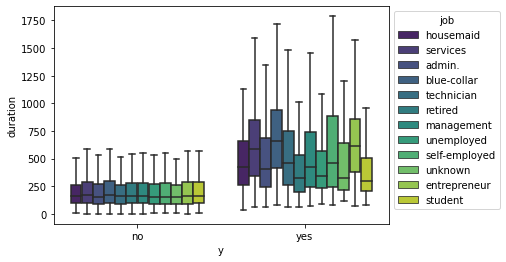

In [14]:
# Boxplot: duration, job and y

ax = sns.boxplot(data=bankdf, x="y", y="duration", hue="job", showfliers=False, palette = "viridis") # ATTENTION not showing outliers
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<AxesSubplot:xlabel='marital', ylabel='age'>

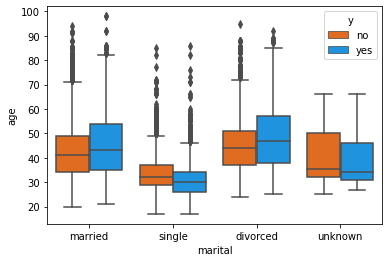

In [15]:
# Boxplot: marital status, age and outcome (y)
sns.boxplot(data=bankdf, x="marital", y="age", hue="y")

In [16]:
# Table of poutcome vs y

tab = pd.crosstab(index=bankdf["poutcome"], 
                            columns=bankdf["y"], margins=True)

tab_per = tab/tab.loc["All","All"]

row = tab_per.index.get_level_values(0)

tab_per.style.background_gradient(
  subset = pd.IndexSlice[row[:-1], 'no'],
  cmap = sns.light_palette("#ff6600", as_cmap = True)).background_gradient(
  subset = pd.IndexSlice[row[:-1], 'yes'],
  cmap = sns.light_palette("#0099ff", as_cmap = True))


y,no,yes,All
poutcome,,,
failure,0.088545,0.014689,0.103234
nonexistent,0.787171,0.076260,0.863431
success,0.011630,0.021705,0.033335
All,0.887346,0.112654,1.000000


In [17]:
tab = pd.crosstab(index=bankdf["education"], 
                            columns=bankdf["y"], margins=True)

tab_per = tab/tab.loc["All",]


row = tab_per.index.get_level_values(0)

tab_per.style.background_gradient(
  subset = pd.IndexSlice[row[:-1], 'no'],
  cmap = sns.light_palette("#ff6600", as_cmap = True)).background_gradient(
  subset = pd.IndexSlice[row[:-1], 'yes'],
  cmap = sns.light_palette("#0099ff", as_cmap = True))

y,no,yes,All
education,,,
basic.4y,0.102550,0.092241,0.101389
basic.6y,0.057568,0.040517,0.055647
basic.9y,0.152457,0.101940,0.146766
high.school,0.232133,0.222198,0.231014
illiterate,0.000383,0.000862,0.000437
professional.course,0.127175,0.128233,0.127294
university.degree,0.287239,0.359914,0.295426
unknown,0.040495,0.054095,0.042027
All,1.000000,1.000000,1.000000


In [18]:
tab = pd.crosstab(index=bankdf["default"], 
                            columns=bankdf["y"], margins=True)

tab_per = tab/tab.loc["All",]


row = tab.index.get_level_values(0)

tab.style.background_gradient(
  subset = pd.IndexSlice[row[:-1], 'no'],
  cmap = sns.light_palette("#ff6600", as_cmap = True)).background_gradient(
  subset = pd.IndexSlice[row[:-1], 'yes'],
  cmap = sns.light_palette("#0099ff", as_cmap = True))

y,no,yes,All
default,,,
no,28391,4197,32588
unknown,8154,443,8597
yes,3,0,3
All,36548,4640,41188


In [19]:
hue_order = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
plt.figure(figsize=(14, 6))
sns.countplot(bankdf, x="year", hue="month_name", hue_order = hue_order, palette= "Paired")

C:\Users\MyName\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret input 'month_name'

<Figure size 1008x432 with 0 Axes>

<h1>PRE-PROCESSING</h1>

- Missing Values: no missing values, but some categorical variables have a class called "Unknown". What should be do with it? How many observations having the Unknown class? <br>
- Scaling: is standardization/normalization required? <br>
- Dummy variables: <br>
- Remove duplicate rows <br>
- Feature Engineering: already performed some operations before<br>
- Remove Columns: pdays? does not make sense. Almost everyone was not contacted before. Can remove it. Already know if have been contacted from the poutcome (nonexistent is not contacted).<br>

In [20]:
# Unknown count

#bankdf.nunique()
#bankdf.isnull().sum() # no NAs but there are some classes "Unknown", what should we do with them?

for column in bankdf.select_dtypes(include=object):
     print("\n" + column)
     print(bankdf[column].value_counts().to_markdown())
    
# job: 330 
# marital: 80
# education: 1731
# default: 8597
# housing 990
# loan: 990



job
|               |   job |
|:--------------|------:|
| admin.        | 10422 |
| blue-collar   |  9254 |
| technician    |  6743 |
| services      |  3969 |
| management    |  2924 |
| retired       |  1720 |
| entrepreneur  |  1456 |
| self-employed |  1421 |
| housemaid     |  1060 |
| unemployed    |  1014 |
| student       |   875 |
| unknown       |   330 |

marital
|          |   marital |
|:---------|----------:|
| married  |     24928 |
| single   |     11568 |
| divorced |      4612 |
| unknown  |        80 |

education
|                     |   education |
|:--------------------|------------:|
| university.degree   |       12168 |
| high.school         |        9515 |
| basic.9y            |        6045 |
| professional.course |        5243 |
| basic.4y            |        4176 |
| basic.6y            |        2292 |
| unknown             |        1731 |
| illiterate          |          18 |

default
|         |   default |
|:--------|----------:|
| no      |     32588 |


In [21]:
# Dealing with Unknowns: 
# in order to preserve interpretability and not lose too many observations, we have decided to remove the Unknowns for the
# following columns: job, marital, education, housing and loan. 
# Furthermore, we decided to keep the Unknown class for the default variables.  

bankdf = bankdf[(bankdf['job'] != "unknown") & (bankdf['marital'] != "unknown") & (bankdf['education'] != "unknown")
                 & (bankdf['housing'] != "unknown") & (bankdf['loan'] != "unknown")]


In [22]:
# High Correlation:
# The social and economic variables are highly-correlated, especially considering emp.var.rate which has some correlations with the 
# other economic variables close to 1.
# We have considered two different approached that could work in this case: (1) dimensionality reduction (for example PCA);
# (2) dropping the emp.var.rate variable. 

# We have decided to go with the second option, since a dimensionality reduction would have been extremely complicated to 
# interpret in the model's results. 

# Furthermore, the same problem concerns the two features called: pdays and previous, containing almost the same kind of 
# information. Additionally, the pdays variable has many values to 999 (indicating no previous calls, that could lead to
# tricky results in the analysis. Thus, we are dropping the pdays. 

bankdf = bankdf.drop(['emp.var.rate', 'pdays'], axis=1)

In [23]:
# Remove duplicates: from 38245 to 38234

bankdf = bankdf.drop_duplicates()
len(bankdf)

38234

In [24]:
# If y is yes, then 1 otherwise 0
bankdf['y'] = np.where(bankdf['y']=='yes', 1, 0)

In [172]:
# If y is yes, then 1 otherwise 0
# bankdf['marital'] = np.where(bankdf['marital']=='married', 1, 0)

In [25]:
# Create Dummy Variables

bank_dummies = pd.get_dummies(bankdf.drop(['month_name', 'date', 'day', 'year'], axis=1), drop_first = True)
bank_dummies.columns 

# dropping year because correlation is too high with the economic and social features (was created starting from those)

Index(['age', 'month', 'duration', 'campaign', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_married', 'marital_single',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'default_unknown', 'default_yes',
       'housing_yes', 'loan_yes', 'contact_telephone', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

<h1>CLASSIFICATION</h1>

Start with: 
- Logistic Regression
- Classification Trees
- KNN

How to improve decision trees (reduce overfitting):
- Random Forests (# features: rule of thumb is max_features=sqrt(n_features))
- XGBoost (learning rate,#trees, max-depth)
- Pruning (both pre and post pruning): max depth, max # leaves, min # points in each node) ->  GRID SEARCH

How to improve logistic regression:
- Lasso regularization
- Ridge regularization
- Discussion about alpha for regularization methods.
- What about changing the threshold? Do we have a preference for FP over FN?

How to improve KNN: 
- think about distance metric used
- k (discuss variance-bias trade-off and decision boundaries meaning)

Feature importance and selection can be done with: 
- Lasso
- Random Forests

<h2 style="color:red;">Logistic Regression</h2>

Dangerous correlations: 
- previous | pdays
- euribor3m | emp.var.rate
- nemployed | emp.var.rate
- cons.price.idx | emp.var.rate

What do we want to do? Could affect the models.... (1) remove the emp.var.rate and either previous or pdays; (2) dimensionality reduction; (3) other options?

In [26]:
# Dataset split into test, validation and training set: 20% or 30 test set? Need validation if use CV?

X = bank_dummies.drop('y', axis=1)
y = bank_dummies["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8) # train and test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=8) # train and validation

print("Xtrain", X_train.shape, "y_train", 
      y_train.shape, "X_test","X_val", X_val.shape, "y_val", 
      y_val.shape, "X_test", X_test.shape, "y_test", y_test.shape) 

Xtrain (24469, 38) y_train (24469,) X_test X_val (6118, 38) y_val (6118,) X_test (7647, 38) y_test (7647,)


In [27]:
# Standardize with .StandardScaler()

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_standardized = scaler.transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)


<h3 style="color:green;">L2 penalty (default, ridge)</h3>

In [28]:
# Logistic Regression, using l2 penalty (Ridge, default)

model_logit = LogisticRegression(random_state = 42) # default penalty is l2..... THINK ABOUT CHANGING SOLVER for easier convergence !!!!!!!!!!!
model_logit.fit(X_train_standardized,y_train)

# print score

print("The score of the training set is: ", model_logit.score(X_train_standardized,y_train)) #  0.9131145531080143
print("The score of the validation set is: ", model_logit.score(X_val_standardized,y_val)) # 0.9128800261523373

The score of the training set is:  0.9131145531080143
The score of the validation set is:  0.9128800261523373


In [29]:
#print coefficient
coefficient = model_logit.coef_
coefficient

array([[-0.00180876, -0.06276754,  1.21940533, -0.13146787,  0.02801005,
         0.12809453,  0.20893491, -0.30394316, -0.70881637, -0.16190114,
        -0.03867748, -0.01199589, -0.03967366,  0.07027851, -0.02788245,
        -0.0987578 ,  0.03236572, -0.03133787,  0.00322906, -0.03665224,
         0.03823205,  0.01699807, -0.03144027, -0.01993444,  0.0278898 ,
         0.01429018,  0.05589213, -0.14850737, -0.059183  , -0.00854809,
        -0.03767069, -0.35895001, -0.02817861,  0.03940917,  0.03628127,
         0.0441366 ,  0.18977806,  0.32993644]])

In [30]:
# odds
odds = np.exp(coefficient)
odds

array([[0.99819288, 0.93916176, 3.38517408, 0.87680745, 1.02840602,
        1.13666045, 1.23236478, 0.73790281, 0.49222647, 0.85052528,
        0.96206094, 0.98807577, 0.96110303, 1.07280693, 0.97250267,
        0.90596211, 1.03289519, 0.96914807, 1.00323428, 0.96401132,
        1.0389723 , 1.01714336, 0.96904884, 0.98026294, 1.02828236,
        1.01439278, 1.0574836 , 0.86199366, 0.94253427, 0.99148835,
        0.96303002, 0.69840927, 0.9722147 , 1.04019601, 1.03694746,
        1.04512511, 1.20898125, 1.39087973]])

<h4 style="color:red;">Interpretation of C in Logistic Regression</h4>

The C parameter in logistic regression controls the inverse of the regularization strength.
This means a smaller value of C specifies stronger regularization, and a larger value specifies weaker regularization. So 0.2 is strong (smaller coefficients), 0.8 is weak.

In [31]:
# Tuning alpha/lambda for Ridge

# CAN DO THE SAME WITH LASSO PENALTY

# define grid
alpha_grid = {
    'C':  np.arange(0.1, 1.1, 0.1)
}

# Set up GridSearchCV 
grid_search = GridSearchCV(model_logit, alpha_grid, cv=10, n_jobs=-1)
alpha_grid

{'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

In [32]:
# Fit the grid search 
grid_search.fit(X_train_standardized, y_train)

# Retrieve and print the scores for each iteration
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f"Accuracy score for {params}: {mean_score}")

# Retrieve the best hyperparameters and the corresponding best estimator
best_alpha = grid_search.best_params_['C']
best_ridge_model = grid_search.best_estimator_

    # Print the best hyperparameters
print(f"Best Alpha for regularization: {best_alpha}")
# Best Alpha for regularization: 0.8

Accuracy score for {'C': 0.1}: 0.9120521365290856
Accuracy score for {'C': 0.2}: 0.9120112534546783
Accuracy score for {'C': 0.30000000000000004}: 0.9120521198216582
Accuracy score for {'C': 0.4}: 0.9120929861886383
Accuracy score for {'C': 0.5}: 0.9120929861886383
Accuracy score for {'C': 0.6}: 0.9120929861886383
Accuracy score for {'C': 0.7000000000000001}: 0.9120929861886383
Accuracy score for {'C': 0.8}: 0.9121338525556182
Accuracy score for {'C': 0.9}: 0.9121338525556182
Accuracy score for {'C': 1.0}: 0.9121338525556182
Best Alpha for regularization: 0.8


In [33]:
# Evaluate the best model on the test data
print(f"Validation Accuracy with best model: {best_ridge_model.score(X_val_standardized, y_val)}")

Validation Accuracy with best model: 0.9128800261523373


In [34]:
coefficient = best_ridge_model.coef_
coefficient

array([[-0.00179364, -0.06251716,  1.21918292, -0.131458  ,  0.02794317,
         0.12873828,  0.20917692, -0.30630866, -0.70684762, -0.16184132,
        -0.03866939, -0.01196371, -0.03965532,  0.07032165, -0.027864  ,
        -0.09872067,  0.03236092, -0.03132007,  0.0032416 , -0.03667339,
         0.03818937,  0.01696263, -0.03147732, -0.01996208,  0.02788687,
         0.01427651,  0.05588926, -0.14849528, -0.05768666, -0.00852956,
        -0.03765885, -0.3587083 , -0.02817151,  0.03940299,  0.03627801,
         0.04413305,  0.18967035,  0.32985   ]])

<h3 style="color:green;">L1 penalty (lasso)</h3>

In [35]:
# lasso Regularization -> GROUP LASSO WOULD BE BETTER!!!!

model_lasso = LogisticRegression(penalty = "l1",solver='liblinear', random_state = 42) # cannot use default solver
model_lasso.fit(X_train_standardized,y_train)

# print score

print("The score of the training set is: ", model_lasso.score(X_train_standardized,y_train))
print("The score of the validation set is: ", model_lasso.score(X_val_standardized,y_val)) 

The score of the training set is:  0.913073685070906
The score of the validation set is:  0.9130434782608695


In [36]:
grid_search = GridSearchCV(model_lasso, alpha_grid, cv=10, n_jobs=-1)

grid_search.fit(X_train_standardized, y_train)

# Retrieve and print the scores for each iteration
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f"Accuracy score for {params}: {mean_score}")

# Retrieve the best hyperparameters and the corresponding best estimator
best_alpha = grid_search.best_params_['C']
best_lasso_model = grid_search.best_estimator_

    # Print the best hyperparameters
print(f"Best Alpha for regularization: {best_alpha}") # 0.8


Accuracy score for {'C': 0.1}: 0.9121338525556182
Accuracy score for {'C': 0.2}: 0.9119703536728438
Accuracy score for {'C': 0.30000000000000004}: 0.9119703536728438
Accuracy score for {'C': 0.4}: 0.9120112200398239
Accuracy score for {'C': 0.5}: 0.9119703536728438
Accuracy score for {'C': 0.6}: 0.9120521031142312
Accuracy score for {'C': 0.7000000000000001}: 0.9120521031142312
Accuracy score for {'C': 0.8}: 0.9121747189225982
Accuracy score for {'C': 0.9}: 0.9121747189225982
Accuracy score for {'C': 1.0}: 0.9121338525556182
Best Alpha for regularization: 0.8


In [37]:
coefficient = best_lasso_model.coef_
coefficient 

# with 0.7 just 1 to 0 - BEST
# with 0.2 a lot to 0

# What's the column to 0?  'education_basic.9y'.... doesn't make sense, would be better to perform a group lasso

array([[-8.83086090e-04, -6.44176907e-02,  1.21830915e+00,
        -1.29006641e-01,  2.54678819e-02,  1.12441264e-01,
         2.01837469e-01, -2.58707708e-01, -7.42966110e-01,
        -1.59382693e-01, -3.70231425e-02, -1.04027213e-02,
        -3.80781300e-02,  7.01444240e-02, -2.64417880e-02,
        -9.72203272e-02,  3.26497860e-02, -2.85066241e-02,
         3.05633071e-03, -3.63323447e-02,  3.83073943e-02,
         1.54156101e-02, -3.12417629e-02, -1.91101833e-02,
         2.73093904e-02,  1.25371985e-02,  5.53608375e-02,
        -1.47663848e-01, -7.52893123e-03, -7.69873500e-03,
        -3.65861483e-02, -3.56951734e-01, -2.87234159e-02,
         3.77402528e-02,  3.44129316e-02,  4.20426242e-02,
         1.86126500e-01,  3.29561604e-01]])

<h2 style="color:red;">KNN</h2>

In [38]:
# KNN

kn = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2) # p is the power parameter for the Minkowski metric (2 Euclidean) 
kn.fit(X_train_standardized,y_train)

print("The score of the training set is: ", kn.score(X_train_standardized,y_train))
print("The score of the validation set is: ", kn.score(X_val_standardized,y_val)) 

The score of the training set is:  0.9224733336057869
The score of the validation set is:  0.8944099378881988


<h3 style="color:green;">How many k? Distance metric? Grid Search</h3>

In [39]:
# The rule of thumb is sqrt(n)
k = math.ceil(math.sqrt(X_train_standardized.shape[0])) # odd number
#163

kn = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=2)  
kn.fit(X_train_standardized,y_train)

print("The score of the training set is: ", kn.score(X_train_standardized,y_train))
print("The score of the validation set is: ", kn.score(X_val_standardized,y_val)) 


The score of the training set is:  0.9006906698271282
The score of the validation set is:  0.8989865969271004


In [40]:
n_neighbors = np.arange(1, k, 5)
accuracy_train =  []
accuracy_val = []

for k in n_neighbors:
    kn_tuning = KNeighborsClassifier(n_neighbors=k) # with Euclidean Distance
    kn_tuning.fit(X_train_standardized,y_train)
    
    accuracy_train.append(kn_tuning.score(X_train_standardized,y_train))
    accuracy_val.append(kn_tuning.score(X_val_standardized,y_val))


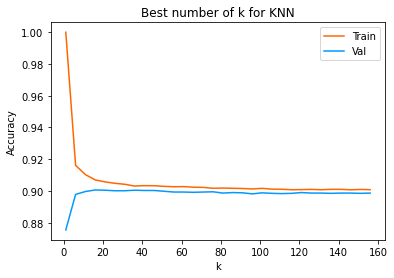

In [41]:
plt.title('Best number of k for KNN')
plt.plot(n_neighbors, accuracy_train, label = 'Train')
plt.plot(n_neighbors, accuracy_val, label = 'Val')
plt.legend()
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

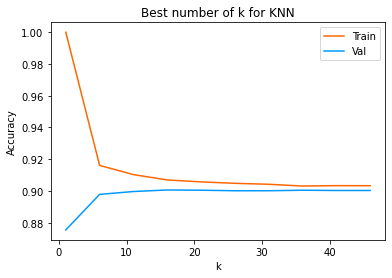

In [42]:
# zoom in

plt.title('Best number of k for KNN')
plt.plot(n_neighbors[:10], accuracy_train[:10], label = 'Train')
plt.plot(n_neighbors[:10], accuracy_val[:10], label = 'Val')
plt.legend()
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

# maybe 15 or 25?

In [43]:
best_k = 15
d = {'k': n_neighbors[:10], 'train': accuracy_train[:10],  'val': accuracy_val[:10]}
results_df = pd.DataFrame(d)

results_df

,k,train,val
0,1,1.000000,0.875449
1,6,0.916098,0.897842
2,11,0.910295,0.899640
3,16,0.906943,0.900621
4,21,0.905717,0.900458
5,26,0.904818,0.900131
6,31,0.904205,0.900131
7,36,0.903102,0.900458
8,41,0.903347,0.900294
9,46,0.903306,0.900294


In [44]:
# KNN with k=15
kn = KNeighborsClassifier(n_neighbors=best_k, weights='uniform', p=1)  
kn.fit(X_train_standardized,y_train)

print("The score of the training set is: ", kn.score(X_train_standardized,y_train))
print("The score of the validation set is: ", kn.score(X_val_standardized,y_val)) 


The score of the training set is:  0.9081286525808165
The score of the validation set is:  0.8999673095782935


In [45]:
# Grid Search for both k and distance (p)

kn_grid = {
    'n_neighbors': np.array([15, 17, 21, 25]),
    'p': np.arange(1, 4) # 1 being Manhattan and 2 being Euclidean, others being Minkowski
}

# our grid: {'n_neighbors': array([15, 17, 21, 25]), 'p': array([1, 2, 3])}

In [46]:
# Set up GridSearchCV - TAKES A LOT OF TIME TO COMPUTE

grid_search = GridSearchCV(KNeighborsClassifier(), kn_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_standardized, y_train)

# Retrieve and print the scores for each iteration
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f"Accuracy score for {params}: {mean_score}")


Accuracy score for {'n_neighbors': 15, 'p': 1}: 0.9018758940300777
Accuracy score for {'n_neighbors': 15, 'p': 2}: 0.9022845242918521
Accuracy score for {'n_neighbors': 15, 'p': 3}: 0.9024071400968048
Accuracy score for {'n_neighbors': 17, 'p': 1}: 0.9014263806973108
Accuracy score for {'n_neighbors': 17, 'p': 2}: 0.9026523800587162
Accuracy score for {'n_neighbors': 17, 'p': 3}: 0.9019575515959808
Accuracy score for {'n_neighbors': 21, 'p': 1}: 0.9013855393863498
Accuracy score for {'n_neighbors': 21, 'p': 2}: 0.9027341545527079
Accuracy score for {'n_neighbors': 21, 'p': 3}: 0.9024888477747457
Accuracy score for {'n_neighbors': 25, 'p': 1}: 0.9013446062033191
Accuracy score for {'n_neighbors': 25, 'p': 2}: 0.9022437163889165
Accuracy score for {'n_neighbors': 25, 'p': 3}: 0.9022845994599091


In [47]:
# Retrieve the best hyperparameters
best_param = grid_search.best_params_
best_param
best_knn_model = grid_search.best_estimator_

    # Print the best hyperparameters
print(f"Best combination of KNN hyperparameters: {best_param}")

# Best combination of KNN hyperparameters: {'n_neighbors': 21, 'p': 2} # 21 neighbors and Manhattan distance

Best combination of KNN hyperparameters: {'n_neighbors': 21, 'p': 2}


In [48]:
best_knn_model

KNeighborsClassifier(n_neighbors=21)

<h2 style="color:red;">Classification Trees</h2>

In [49]:
# Classification Trees

dtree = tree.DecisionTreeClassifier(max_depth = 3) 
dtree.fit(X_train_standardized, y_train) 
print("The score of the training set is: ", dtree.score(X_train_standardized, y_train)) # 0.1.....OVERFITTING
print("The score of the validation set is: ", dtree.score(X_val_standardized, y_val))


The score of the training set is:  0.9111528873268216
The score of the validation set is:  0.9109186008499509


[Text(0.5, 0.875, 'nr.employed <= -1.11\ngini = 0.196\nsamples = 24469\nvalue = [21768, 2701]'),
 Text(0.25, 0.625, 'duration <= -0.369\ngini = 0.493\nsamples = 2858\nvalue = [1598, 1260]'),
 Text(0.125, 0.375, 'duration <= -0.532\ngini = 0.269\nsamples = 1030\nvalue = [865, 165]'),
 Text(0.0625, 0.125, 'gini = 0.166\nsamples = 635\nvalue = [577, 58]'),
 Text(0.1875, 0.125, 'gini = 0.395\nsamples = 395\nvalue = [288, 107]'),
 Text(0.375, 0.375, 'poutcome_success <= 2.655\ngini = 0.48\nsamples = 1828\nvalue = [733, 1095]'),
 Text(0.3125, 0.125, 'gini = 0.5\nsamples = 1344\nvalue = [655, 689]'),
 Text(0.4375, 0.125, 'gini = 0.27\nsamples = 484\nvalue = [78, 406]'),
 Text(0.75, 0.625, 'duration <= 1.362\ngini = 0.124\nsamples = 21611\nvalue = [20170, 1441]'),
 Text(0.625, 0.375, 'duration <= 0.661\ngini = 0.059\nsamples = 19864\nvalue = [19255, 609]'),
 Text(0.5625, 0.125, 'gini = 0.037\nsamples = 18285\nvalue = [17942, 343]'),
 Text(0.6875, 0.125, 'gini = 0.28\nsamples = 1579\nvalue = [1

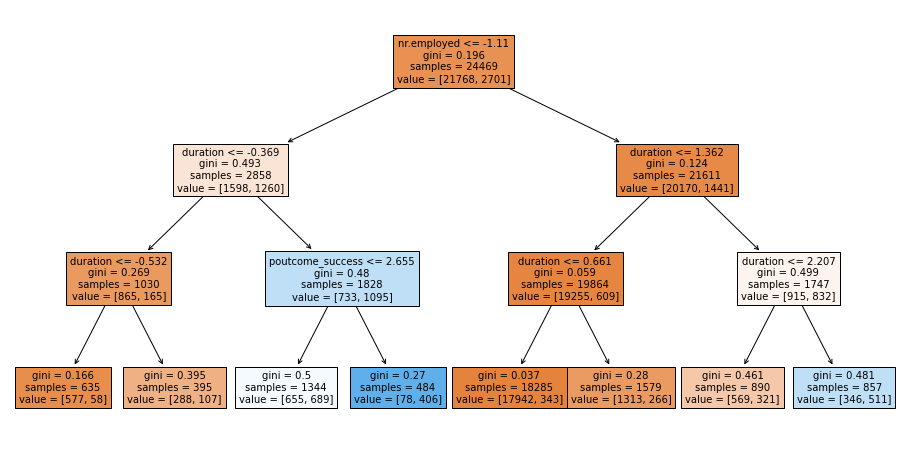

In [50]:
plt.figure(figsize=(16,8))
tree.plot_tree(dtree,
               feature_names=list(X_train.columns), 
               filled=True, # color nodes to indicate majority class
               fontsize=10) 
#plt.savefig('big_tree.png', bbox_inches='tight') 

<h3 style="color:green;">Pre-Pruning: max_depth, min_samples_leaf and min_samples_split</h3>

In [51]:
# Pruning: max_depth, min_samples_leaf and min_samples_split

y_axis = []
for max_d in range(1,21):
    dtree = tree.DecisionTreeClassifier(max_depth=max_d, random_state=42)
    dtree.fit(X_train_standardized, y_train)
    y_axis.append(dtree.score(X_train_standardized, y_train))
    print('The Training Accuracy for max_depth {} is:'.format(max_d), dtree.score(X_train_standardized, y_train))


The Training Accuracy for max_depth 1 is: 0.889615431770812
The Training Accuracy for max_depth 2 is: 0.9044096612039724
The Training Accuracy for max_depth 3 is: 0.9111528873268216
The Training Accuracy for max_depth 4 is: 0.9170378846703993
The Training Accuracy for max_depth 5 is: 0.9205116678245944
The Training Accuracy for max_depth 6 is: 0.9233315623850586
The Training Accuracy for max_depth 7 is: 0.9274592341329846
The Training Accuracy for max_depth 8 is: 0.9327720789570477
The Training Accuracy for max_depth 9 is: 0.9387388123748417
The Training Accuracy for max_depth 10 is: 0.9463402672769626
The Training Accuracy for max_depth 11 is: 0.9530017573255957
The Training Accuracy for max_depth 12 is: 0.9618701213780703
The Training Accuracy for max_depth 13 is: 0.9691037639462177
The Training Accuracy for max_depth 14 is: 0.9767869549225551
The Training Accuracy for max_depth 15 is: 0.9835301810454044
The Training Accuracy for max_depth 16 is: 0.9886795537210348
The Training Accur

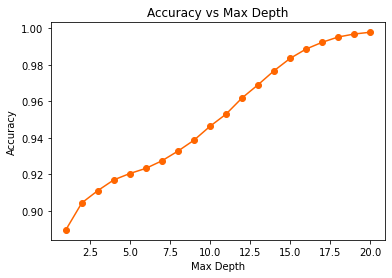

In [52]:
x_axis = range(1,21,1)
y_axis

plt.plot(x_axis, y_axis, marker = 'o')
plt.title("Accuracy vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.show()

In [53]:
tree_grid = {'criterion':['gini','entropy'],
              'max_depth':np.arange(1,21,2).tolist(),
              'min_samples_split':np.arange(2,11,2).tolist(),
              'max_leaf_nodes':np.arange(3,26).tolist()}

# create an instance of the grid search object
grid_search = GridSearchCV(tree.DecisionTreeClassifier(), tree_grid, cv=5, n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train_standardized, y_train)
duration = time.time() - start_time
# 294.6703038215637 seconds

In [54]:
# Retrieve and print the scores for each iteration
cv_results = grid_search.cv_results_

# Retrieve the best hyperparameters
best_param = grid_search.best_params_
best__tunedtree_model = grid_search.best_estimator_

    # Print the best hyperparameters
print(f"Best combination of hyperparameters: {best_param}")

# Best combination of hyperparameters: {'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 23, 'min_samples_split': 2}

Best combination of hyperparameters: {'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 23, 'min_samples_split': 2}


In [55]:
best__tunedtree_model = tree.DecisionTreeClassifier(criterion= 'gini', max_depth= 7, max_leaf_nodes= 25,
                                                    min_samples_split= 2, random_state = 42)

best__tunedtree_model.fit(X_train_standardized, y_train)

print("The score of the training set is: ", best__tunedtree_model.score(X_train_standardized,y_train))
print("The score of the validation set is: ", best__tunedtree_model.score(X_val_standardized,y_val)) 

The score of the training set is:  0.9198169111937554
The score of the validation set is:  0.914187643020595


[Text(0.4947916666666667, 0.9375, 'nr.employed <= -1.11\ngini = 0.196\nsamples = 24469\nvalue = [21768, 2701]'),
 Text(0.20833333333333334, 0.8125, 'duration <= -0.369\ngini = 0.493\nsamples = 2858\nvalue = [1598, 1260]'),
 Text(0.1111111111111111, 0.6875, 'duration <= -0.532\ngini = 0.269\nsamples = 1030\nvalue = [865, 165]'),
 Text(0.05555555555555555, 0.5625, 'poutcome_success <= 2.655\ngini = 0.166\nsamples = 635\nvalue = [577, 58]'),
 Text(0.027777777777777776, 0.4375, 'gini = 0.124\nsamples = 556\nvalue = [519, 37]'),
 Text(0.08333333333333333, 0.4375, 'gini = 0.39\nsamples = 79\nvalue = [58, 21]'),
 Text(0.16666666666666666, 0.5625, 'poutcome_success <= 2.655\ngini = 0.395\nsamples = 395\nvalue = [288, 107]'),
 Text(0.1388888888888889, 0.4375, 'gini = 0.351\nsamples = 317\nvalue = [245, 72]'),
 Text(0.19444444444444445, 0.4375, 'gini = 0.495\nsamples = 78\nvalue = [43, 35]'),
 Text(0.3055555555555556, 0.6875, 'poutcome_success <= 2.655\ngini = 0.48\nsamples = 1828\nvalue = [733,

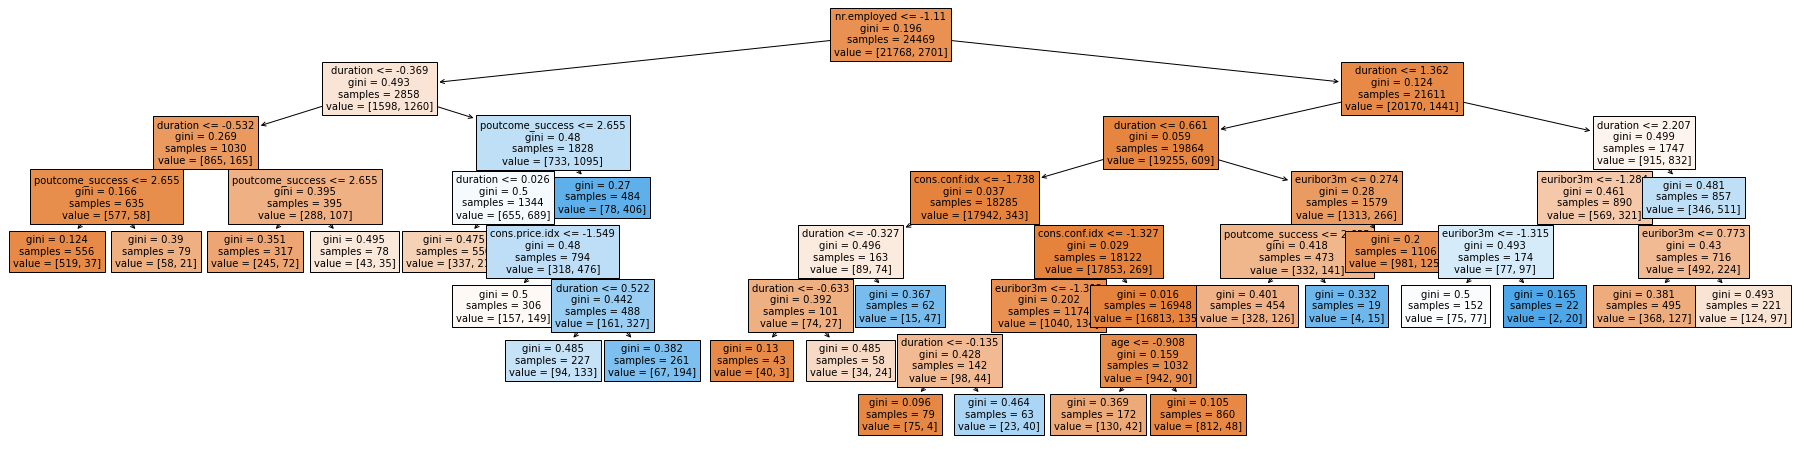

In [56]:
plt.figure(figsize=(32,8))
tree.plot_tree(best__tunedtree_model,
               feature_names=list(X_train.columns), 
               filled=True, 
               fontsize=10) 

<h3 style="color:green;">Post-Pruning: ccp_alphas</h3>

In [57]:
# Post-Pruning

# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

dtree = tree.DecisionTreeClassifier(random_state=42) 
path = dtree.cost_complexity_pruning_path(X_train_standardized, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

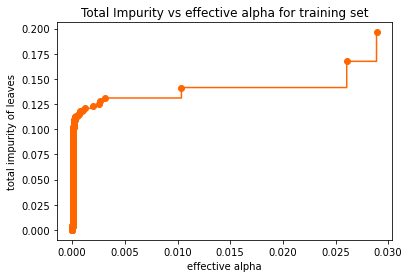

In [58]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree with one node.

In [59]:
clfs = [] #building the different decision trees for each ccp_alpha
for ccp_alpha in ccp_alphas:
    dtree = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    dtree.fit(X_train_standardized, y_train)
    clfs.append(dtree)

# Number of nodes in the last tree is: 1 with ccp_alpha: 0.030825392051844147

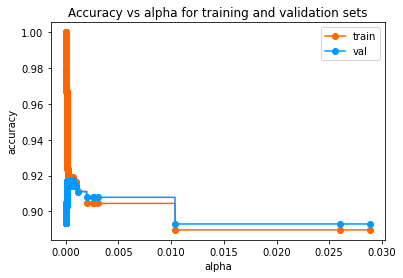

In [60]:
train_scores =[]
val_scores =[]

for tree in clfs: 
    train_scores.append(tree.score(X_train_standardized, y_train))
    val_scores.append(tree.score(X_val_standardized, y_val))
    
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker="o", label="val", drawstyle="steps-post")
ax.legend()
plt.show()

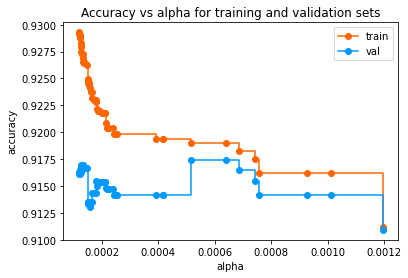

In [61]:
# zoom in of previous plot

#len(ccp_alphas)

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas[700:-7], train_scores[700:-7],marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[700:-7], val_scores[700:-7], marker="o",label="val", drawstyle="steps-post")
ax.legend()
plt.show()

In [62]:
d = {'ccp_alpha':ccp_alphas[700:-7], 'train': train_scores[700:-7],  'val': val_scores[700:-7]}
results_df = pd.DataFrame(d)
results_df

# Best ccp_alpha: 0.000516
best_ccp_alpha = float(0.000516)

In [70]:
#from sklearn import tree
best_posttree_model = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=best_ccp_alpha)

best_posttree_model.fit(X_train_standardized, y_train) 
print("The score of the training set is: ", best_posttree_model.score(X_train_standardized, y_train))
print("The score of the validation set is: ", best_posttree_model.score(X_val_standardized, y_val))


The score of the training set is:  0.9190404184887
The score of the validation set is:  0.917456685191239


[Text(0.4602272727272727, 0.9375, 'nr.employed <= -1.11\ngini = 0.196\nsamples = 24469\nvalue = [21768, 2701]'),
 Text(0.18181818181818182, 0.8125, 'duration <= -0.369\ngini = 0.493\nsamples = 2858\nvalue = [1598, 1260]'),
 Text(0.09090909090909091, 0.6875, 'duration <= -0.532\ngini = 0.269\nsamples = 1030\nvalue = [865, 165]'),
 Text(0.045454545454545456, 0.5625, 'gini = 0.166\nsamples = 635\nvalue = [577, 58]'),
 Text(0.13636363636363635, 0.5625, 'gini = 0.395\nsamples = 395\nvalue = [288, 107]'),
 Text(0.2727272727272727, 0.6875, 'poutcome_success <= 2.655\ngini = 0.48\nsamples = 1828\nvalue = [733, 1095]'),
 Text(0.22727272727272727, 0.5625, 'duration <= 0.026\ngini = 0.5\nsamples = 1344\nvalue = [655, 689]'),
 Text(0.18181818181818182, 0.4375, 'gini = 0.475\nsamples = 550\nvalue = [337, 213]'),
 Text(0.2727272727272727, 0.4375, 'gini = 0.48\nsamples = 794\nvalue = [318, 476]'),
 Text(0.3181818181818182, 0.5625, 'gini = 0.27\nsamples = 484\nvalue = [78, 406]'),
 Text(0.738636363636

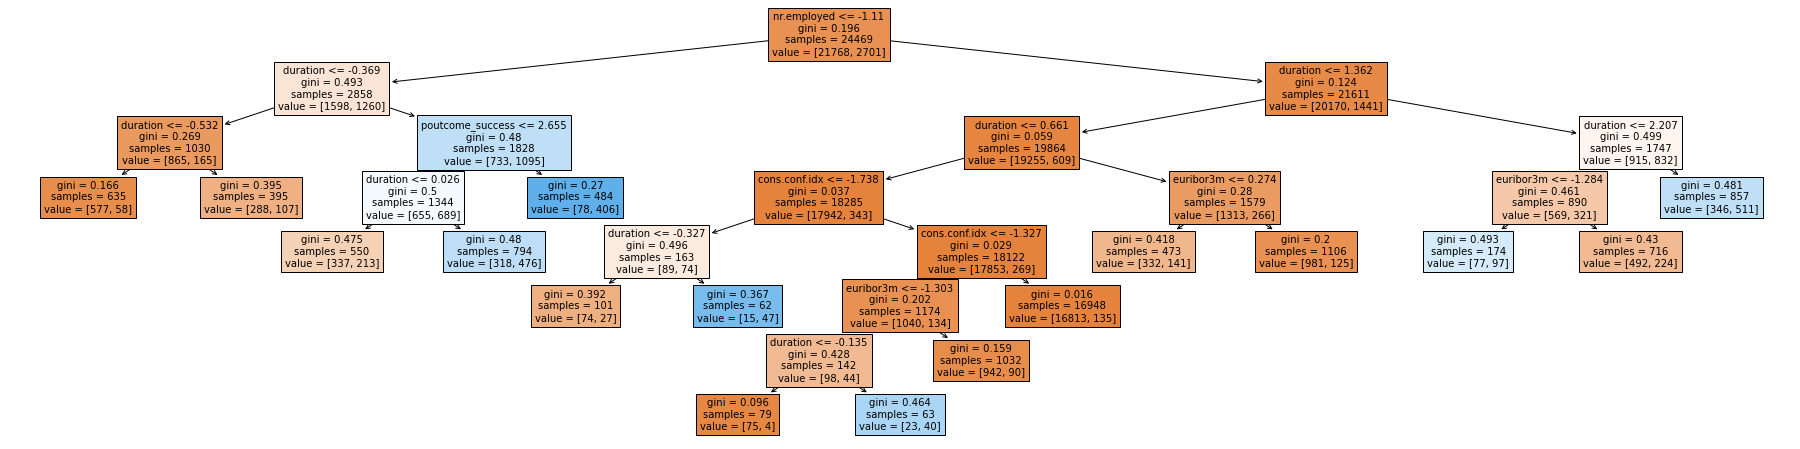

In [71]:
plt.figure(figsize=(32,8))
tree.plot_tree(best_posttree_model,
               feature_names=list(X_train.columns), 
               filled=True, 
               fontsize=10) 

<h2 style="color:red;">Ensamble Methods</h2>

<h3 style="color:green;">Random Forests</h3>

In [72]:
# Random Forests

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42) # everything default

rf.fit(X_train_standardized, y_train)

print("Accuracy on training set: {:.3f}".format(rf.score(X_train_standardized, y_train))) # 1.... OVERFITTING!!!
print("Accuracy on validation set: {:.3f}".format(rf.score(X_val_standardized, y_val)))

Accuracy on training set: 1.000
Accuracy on validation set: 0.914


Parameters to tune: 

- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

In [73]:
# Tuning parameters: CHECK THE GRID.... IS IT REASONABLE??????

param_grid = {
    'max_depth': np.arange(10, 100, 10),
    'max_features': np.arange(2,30,2),
    'min_samples_leaf': np.arange(5,30,5),
    'min_samples_split': np.arange(2,20,2),
    'n_estimators': np.arange(10,400,10)
}

In [74]:
# RANDOM SEARCH (not GRID... too computationally expensive with RF....)

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(RandomForestClassifier(random_state = 42), param_grid, cv=5, n_jobs=-1, random_state=42)

start_time = time.time()
random_search.fit(X_train_standardized, y_train)
duration = time.time() - start_time

In [75]:
# Retrieve and print the scores for each iteration
cv_results = random_search.cv_results_

# Retrieve the best hyperparameters
best_param = random_search.best_params_
best_rf_model = random_search.best_estimator_

    # Print the best hyperparameters
print(f"Best combination of hyperparameters: {best_param}")

# {'n_estimators': 350, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 12, 'max_depth': 60}

Best combination of hyperparameters: {'n_estimators': 350, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 12, 'max_depth': 60}


In [76]:
best_rf_model.fit(X_train_standardized, y_train)

print("The score of the training set is: ", best_rf_model.score(X_train_standardized,y_train))
print("The score of the validation set is: ", best_rf_model.score(X_val_standardized,y_val)) 

The score of the training set is:  0.9532060975111365
The score of the validation set is:  0.915822164105917


Text(0.5, 0, 'Importance')

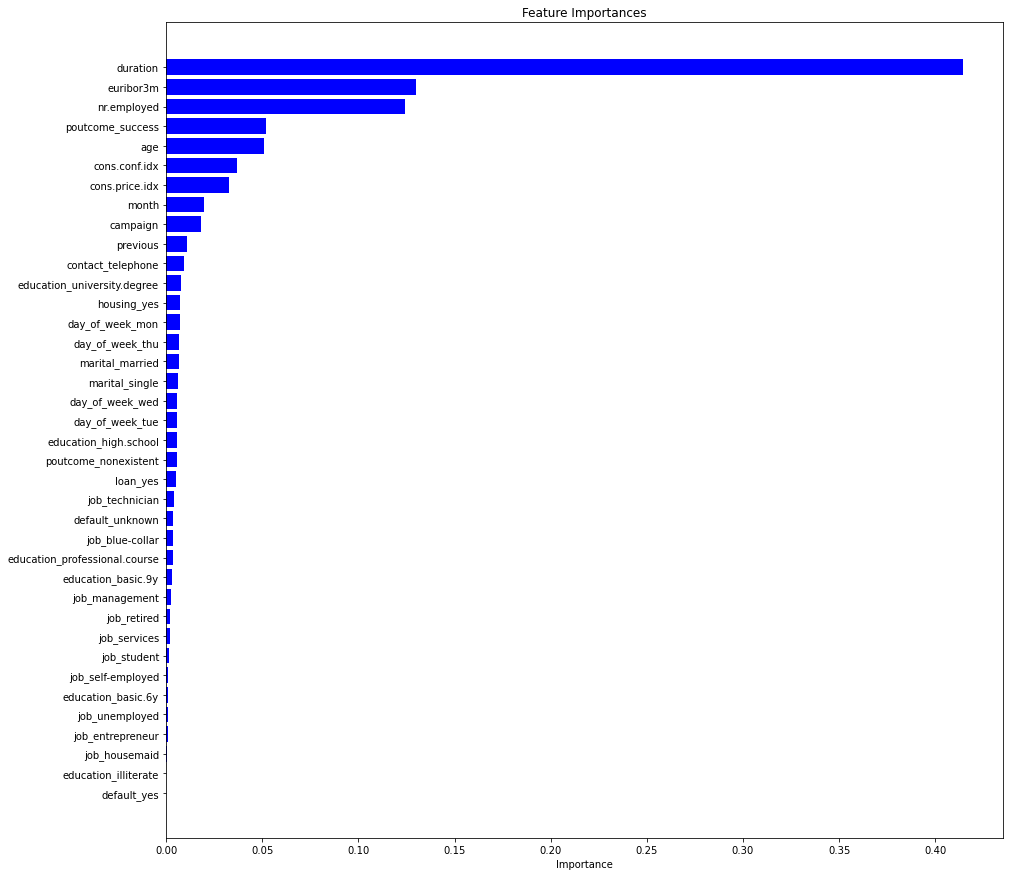

In [77]:
feature_importance = best_rf_model.feature_importances_
features= X_train.columns
indices = np.argsort(feature_importance)

plt.figure(figsize=(15,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importance')

<h3 style="color:green;">XGBoost</h3>

In [78]:
# XGBoost
gboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, # everything default
                                    max_depth=3, random_state=42)


gboost.fit(X_train_standardized, y_train) 
print("The score of the training set is: ", gboost.score(X_train_standardized, y_train)) 
print("The score of the validation set is: ", gboost.score(X_val_standardized, y_val))

The score of the training set is:  0.9267644775021455
The score of the validation set is:  0.9161490683229814


In [79]:
# Tuning the Gradient Boosting parameters

# Choosing max_features < n_features leads to a reduction of variance and an increase in bias.

# BOOSTING PARAMETERS: learning_rate, n_estimators and subsample
# TREE SPECIFIC: using the optimal of decision trees ('gini', 'max_depth': 7, 'max_leaf_nodes': 25, 'min_samples_split': 2)


gb_grid = {'n_estimators':range(10,100,10),
             'subsample':[0.6,0.7,0.8,0.9],
             'learning_rate': np.arange(0,1.1,0.1)}

# create an instance of the grid search object
grid_search = GridSearchCV(GradientBoostingClassifier(max_depth = 7, max_leaf_nodes = 25, min_samples_split = 2,random_state = 42), 
                           gb_grid, cv=3, n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train_standardized, y_train)
duration = time.time() - start_time # 975.2196888923645 approx 16 minutes 

In [80]:
# Retrieve the best hyperparameters
best_param = grid_search.best_params_
best_gboost = grid_search.best_estimator_

    # Print the best hyperparameters
print(f"Best: {best_param}") 

# Best: {'learning_rate': 0.2, 'n_estimators': 40, 'subsample': 0.9}

Best: {'learning_rate': 0.1, 'n_estimators': 30, 'subsample': 0.7}


In [81]:
print("The score of the training set is: ", best_gboost.score(X_train_standardized, y_train)) 
print("The score of the validation set is: ", best_gboost.score(X_val_standardized, y_val))

The score of the training set is:  0.931014753361396
The score of the validation set is:  0.9163125204315136


Text(0.5, 0, 'Importance')

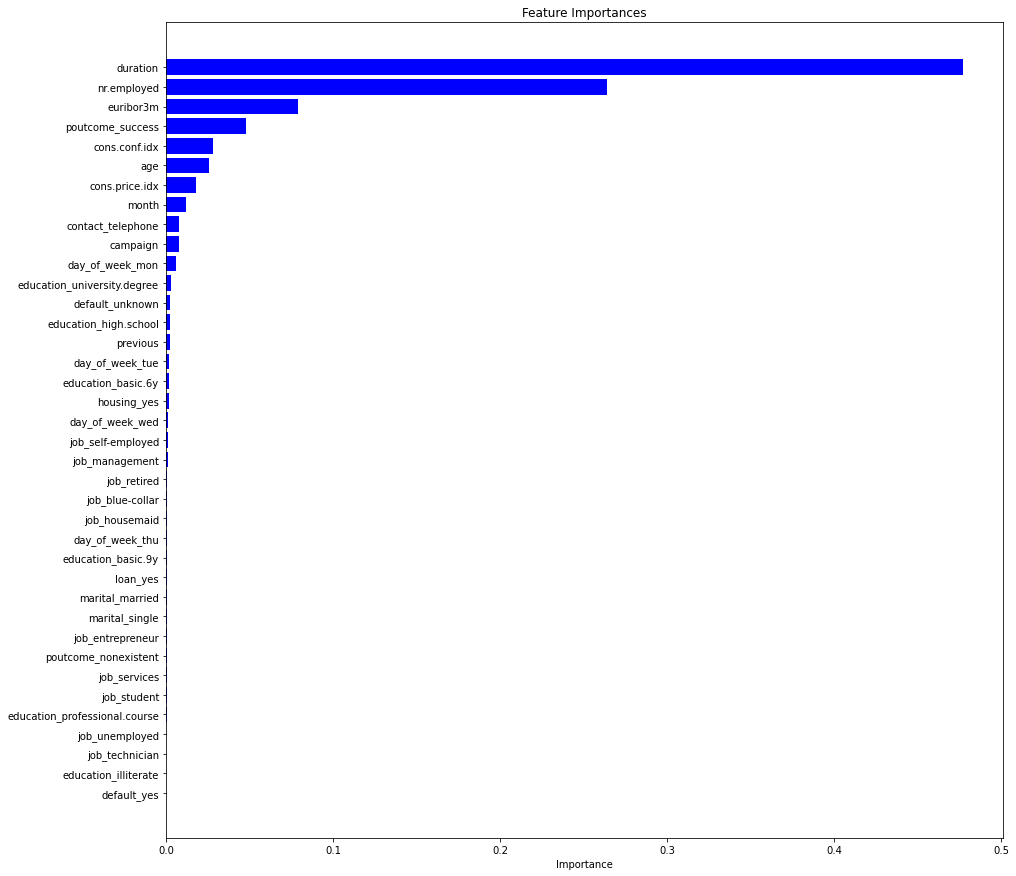

In [82]:
feature_importance = best_gboost.feature_importances_
features= X_train.columns
indices = np.argsort(feature_importance)

plt.figure(figsize=(15,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importance')

<h1>EVALUATION</h1>

- Confusion Matrix
- Classification_report
- ROC and AUC
<br><br>

- Precision
- Accuracy
- Recall (Sensitivity)
- F1 score (*)
- Specificity
- Expected value


And discussion about the meaning

## Confusion Matrices, Classification Reports and ROC/AUC

[[6564  182]
 [ 553  348]]


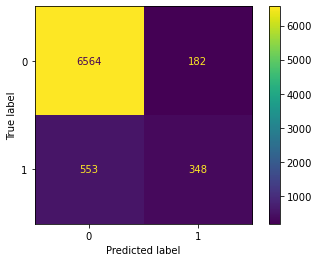

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      6746
           1       0.66      0.39      0.49       901

    accuracy                           0.90      7647
   macro avg       0.79      0.68      0.72      7647
weighted avg       0.89      0.90      0.89      7647



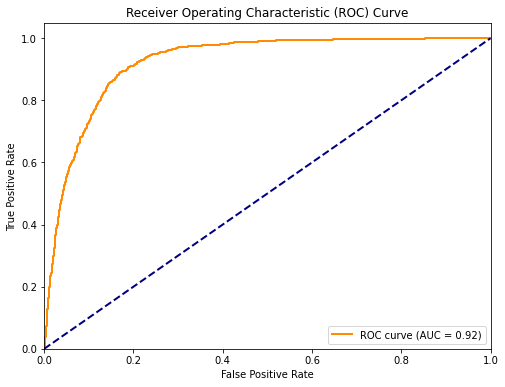

In [87]:
# Model_Logit
model_logit_y_pred=model_logit.predict(X_test_standardized)
cm_model_logit = confusion_matrix(y_test, model_logit_y_pred)

# Print Confusion Matrix
print(cm_model_logit)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_model_logit,
                               display_labels=model_logit.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, model_logit_y_pred))

# ROC and AUC
y_prob_model_logit = model_logit.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_model_logit)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[[6564  182]
 [ 553  348]]


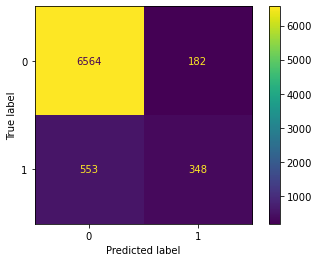

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      6746
           1       0.66      0.39      0.49       901

    accuracy                           0.90      7647
   macro avg       0.79      0.68      0.72      7647
weighted avg       0.89      0.90      0.89      7647



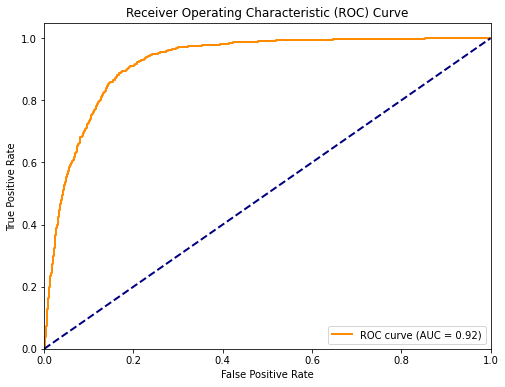

In [88]:
# best_ridge_model
best_ridge_model_y_pred=best_ridge_model.predict(X_test_standardized)
cm_best_ridge_model = confusion_matrix(y_test, best_ridge_model_y_pred)

# Print Confusion Matrix
print(cm_best_ridge_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_ridge_model,
                               display_labels=best_ridge_model.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, best_ridge_model_y_pred))

# ROC and AUC
y_prob_best_ridge_model = best_ridge_model.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best_ridge_model)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[[6564  182]
 [ 555  346]]


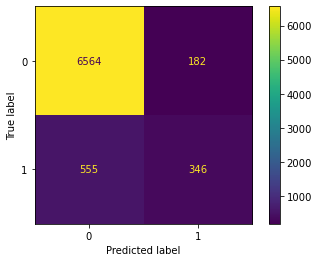

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      6746
           1       0.66      0.38      0.48       901

    accuracy                           0.90      7647
   macro avg       0.79      0.68      0.72      7647
weighted avg       0.89      0.90      0.89      7647



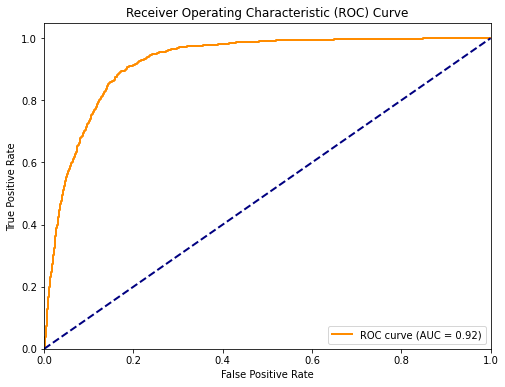

In [91]:
# best_lasso_model
best_lasso_model_y_pred=best_lasso_model.predict(X_test_standardized)
cm_best_lasso_model = confusion_matrix(y_test, best_lasso_model_y_pred)

# Print Confusion Matrix
print(cm_best_lasso_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_lasso_model,
                               display_labels=best_lasso_model.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, best_lasso_model_y_pred))

# ROC and AUC
y_prob_best_lasso_model = best_lasso_model.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best_lasso_model)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[[6661   85]
 [ 718  183]]


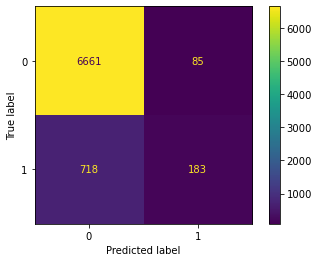

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6746
           1       0.68      0.20      0.31       901

    accuracy                           0.89      7647
   macro avg       0.79      0.60      0.63      7647
weighted avg       0.88      0.89      0.87      7647



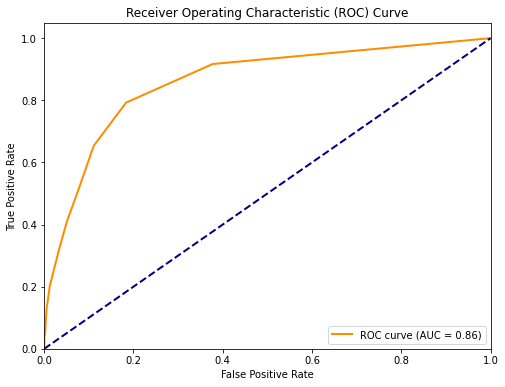

In [92]:
# kn
kn_y_pred=kn.predict(X_test_standardized)
cm_kn = confusion_matrix(y_test, kn_y_pred)

# Print Confusion Matrix
print(cm_kn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_kn,
                               display_labels=kn.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, kn_y_pred))

# ROC and AUC
y_prob_kn = kn.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_kn)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[[6637  109]
 [ 695  206]]


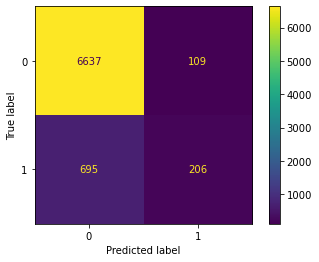

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      6746
           1       0.65      0.23      0.34       901

    accuracy                           0.89      7647
   macro avg       0.78      0.61      0.64      7647
weighted avg       0.88      0.89      0.87      7647



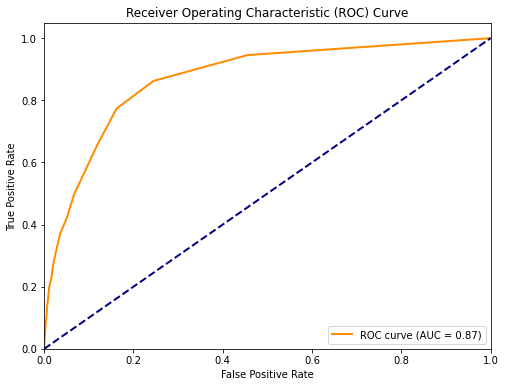

In [93]:
# best_knn_model
best_knn_model_y_pred=best_knn_model.predict(X_test_standardized)
cm_best_knn_model = confusion_matrix(y_test, best_knn_model_y_pred)

# Print Confusion Matrix
print(cm_best_knn_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_knn_model,
                               display_labels=best_knn_model.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, best_knn_model_y_pred))

# ROC and AUC
y_prob_best_knn_model = best_knn_model.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best_knn_model)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[[6746    0]
 [ 901    0]]


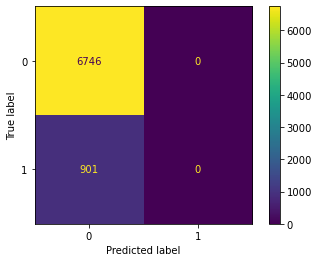

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6746
           1       0.00      0.00      0.00       901

    accuracy                           0.88      7647
   macro avg       0.44      0.50      0.47      7647
weighted avg       0.78      0.88      0.83      7647



C:\Users\MyName\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MyName\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MyName\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


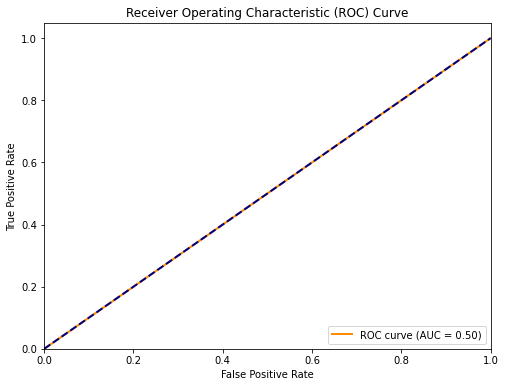

In [94]:
# dtree
dtree_y_pred=dtree.predict(X_test_standardized)
cm_dtree = confusion_matrix(y_test, dtree_y_pred)

# Print Confusion Matrix
print(cm_dtree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtree,
                               display_labels=dtree.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, dtree_y_pred))

# ROC and AUC
y_prob_dtree = dtree.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_dtree)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[[6501  245]
 [ 465  436]]


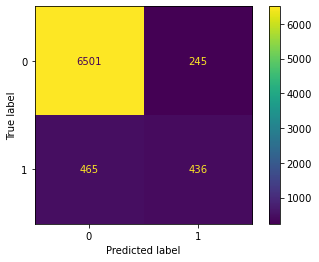

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      6746
           1       0.64      0.48      0.55       901

    accuracy                           0.91      7647
   macro avg       0.79      0.72      0.75      7647
weighted avg       0.90      0.91      0.90      7647



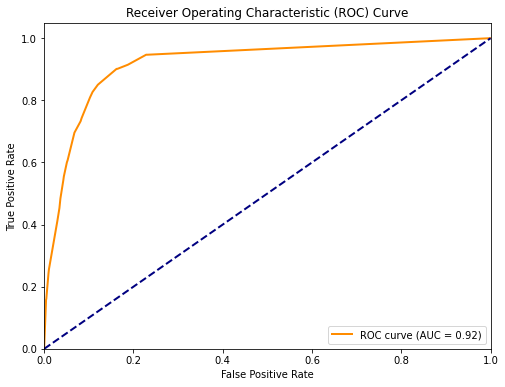

In [96]:
# best__tunedtree_model
best__tunedtree_model_y_pred=best__tunedtree_model.predict(X_test_standardized)
cm_best__tunedtree_model = confusion_matrix(y_test, best__tunedtree_model_y_pred)

# Print Confusion Matrix
print(cm_best__tunedtree_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best__tunedtree_model,
                               display_labels=best__tunedtree_model.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, best__tunedtree_model_y_pred))

# ROC and AUC
y_prob_best__tunedtree_model = best__tunedtree_model.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best__tunedtree_model)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[[6461  285]
 [ 415  486]]


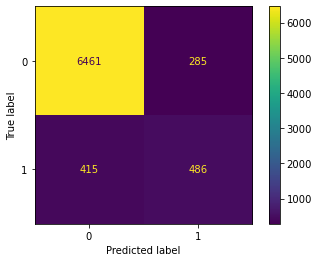

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6746
           1       0.63      0.54      0.58       901

    accuracy                           0.91      7647
   macro avg       0.78      0.75      0.76      7647
weighted avg       0.90      0.91      0.91      7647



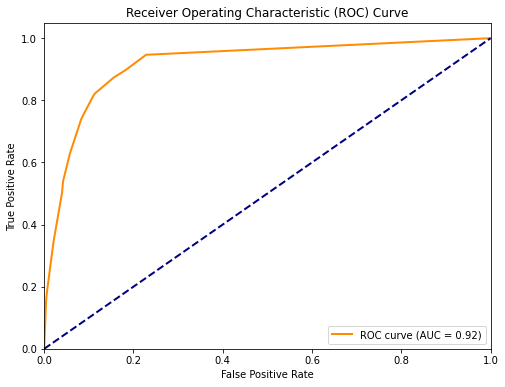

In [97]:
# best_posttree_model
best_posttree_model_y_pred=best_posttree_model.predict(X_test_standardized)
cm_best_posttree_model = confusion_matrix(y_test, best_posttree_model_y_pred)

# Print Confusion Matrix
print(cm_best_posttree_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_posttree_model,
                               display_labels=best_posttree_model.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, best_posttree_model_y_pred))

# ROC and AUC
y_prob_best_posttree_model = best_posttree_model.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best_posttree_model)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[[6515  231]
 [ 470  431]]


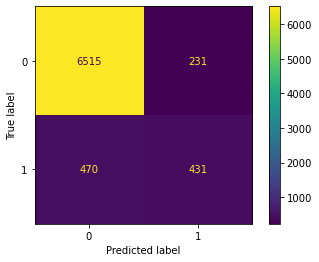

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6746
           1       0.65      0.48      0.55       901

    accuracy                           0.91      7647
   macro avg       0.79      0.72      0.75      7647
weighted avg       0.90      0.91      0.90      7647



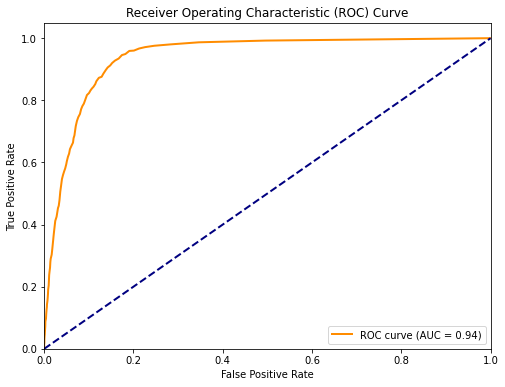

In [98]:
# rf
rf_y_pred=rf.predict(X_test_standardized)
cm_rf = confusion_matrix(y_test, rf_y_pred)

# Print Confusion Matrix
print(cm_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                               display_labels=rf.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, rf_y_pred))

# ROC and AUC
y_prob_rf = rf.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[[6496  250]
 [ 434  467]]


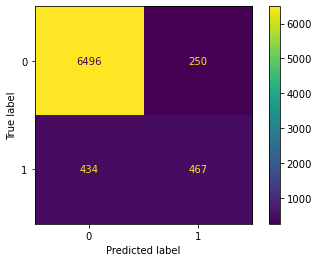

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6746
           1       0.65      0.52      0.58       901

    accuracy                           0.91      7647
   macro avg       0.79      0.74      0.76      7647
weighted avg       0.90      0.91      0.91      7647



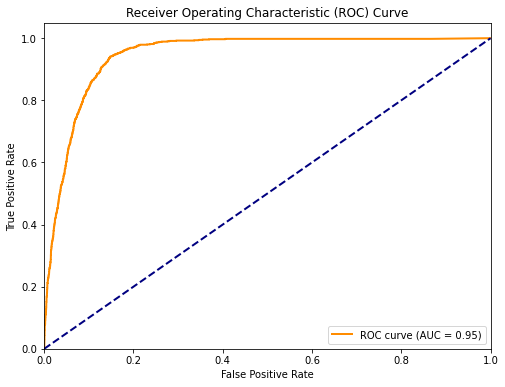

In [100]:
# best_rf_model
best_rf_model_y_pred=best_rf_model.predict(X_test_standardized)
cm_best_rf_model = confusion_matrix(y_test, best_rf_model_y_pred)

# Print Confusion Matrix
print(cm_best_rf_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_rf_model,
                               display_labels=best_rf_model.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, best_rf_model_y_pred))

# ROC and AUC
y_prob_best_rf_model = best_rf_model.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best_rf_model)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[[6514  232]
 [ 447  454]]


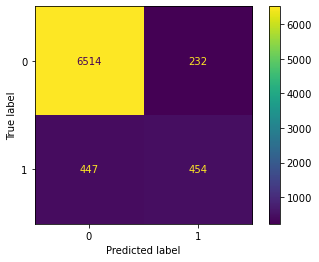

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      6746
           1       0.66      0.50      0.57       901

    accuracy                           0.91      7647
   macro avg       0.80      0.73      0.76      7647
weighted avg       0.90      0.91      0.91      7647



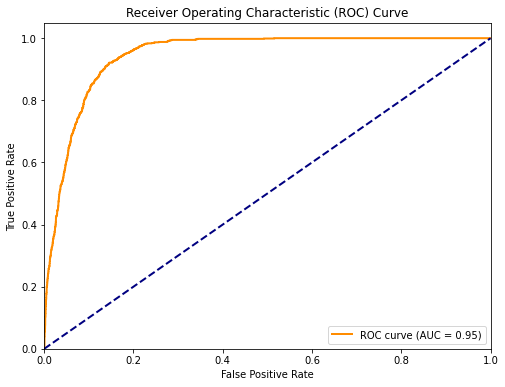

In [102]:
# gboost
gboost_y_pred=gboost.predict(X_test_standardized)
cm_gboost = confusion_matrix(y_test, gboost_y_pred)

# Print Confusion Matrix
print(cm_gboost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gboost,
                               display_labels=gboost.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, gboost_y_pred))

# ROC and AUC
y_prob_gboost = gboost.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gboost)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[[6502  244]
 [ 441  460]]


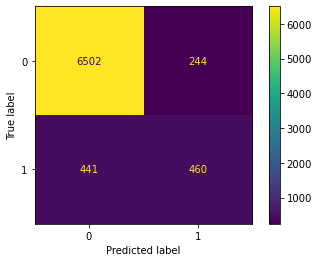

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6746
           1       0.65      0.51      0.57       901

    accuracy                           0.91      7647
   macro avg       0.79      0.74      0.76      7647
weighted avg       0.90      0.91      0.91      7647



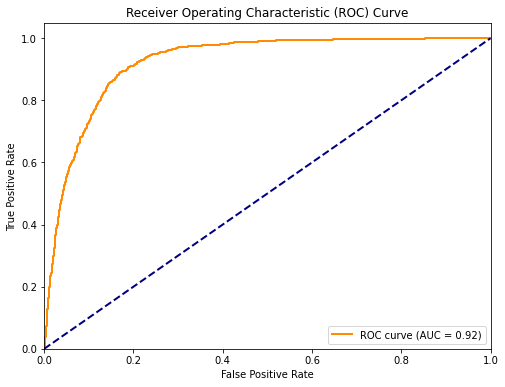

In [103]:
# best_gboost
best_gboost_y_pred=best_gboost.predict(X_test_standardized)
cm_best_gboost = confusion_matrix(y_test, best_gboost_y_pred)

# Print Confusion Matrix
print(cm_best_gboost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_gboost,
                               display_labels=best_gboost.classes_)
disp.plot()
plt.show()

# Print Classification Report
print(classification_report(y_test, best_gboost_y_pred))

# ROC and AUC
y_prob_best_gboost = best_gboost.predict_proba(X_test_standardized)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_model_logit)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<h1>ETHICS and FAIRNESS</h1>

Demographic variables are: age, marital, education, job, housing

 - demographic parity
 - equality of odds
 
Then
- reduce unfairness

In [ ]:
## doesnt compute

# 1) Age groups?
# 2) How marital, job, education and housing attributes?
# 3) postprocessor.fit doesnt work... weird mistake

In [144]:
columns = X_test.columns
X_test_standardized = pd.DataFrame(X_test_standardized)
X_test_standardized.columns = columns
X_test_standardized

,age,month,duration,campaign,previous,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,...,default_yes,housing_yes,loan_yes,contact_telephone,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,0.986126,-0.787429,-0.797316,-0.570266,-0.350656,-1.180444,-1.229214,-1.343432,-0.950299,-0.534361,...,-0.009041,-1.081847,2.320296,1.325194,1.944471,-0.514914,-0.495475,-0.493747,0.395725,-0.182057
1,-1.248376,-0.787429,-0.700470,-0.204915,-0.350656,-1.180444,-1.229214,-1.311657,-0.950299,-0.534361,...,-0.009041,0.924345,-0.430980,-0.754607,1.944471,-0.514914,-0.495475,-0.493747,0.395725,-0.182057
2,1.860496,0.676934,-0.781821,0.891136,-0.350656,-0.221588,0.957361,0.774537,0.845390,-0.534361,...,-0.009041,0.924345,2.320296,-0.754607,1.944471,-0.514914,-0.495475,-0.493747,0.395725,-0.182057
3,-0.471158,2.141297,0.492672,0.160435,3.785373,2.080710,-2.225081,-1.495954,-2.836468,-0.534361,...,-0.009041,0.924345,-0.430980,-0.754607,-0.514279,-0.514914,2.018266,-0.493747,-2.527005,5.492786
4,-1.054072,0.188813,-0.355698,1.256487,-0.350656,0.603272,-0.471490,0.769915,0.845390,-0.534361,...,-0.009041,0.924345,2.320296,-0.754607,-0.514279,-0.514914,-0.495475,2.025330,0.395725,-0.182057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7642,1.860496,0.188813,-0.661732,4.909991,-0.350656,0.603272,-0.471490,0.769915,0.845390,-0.534361,...,-0.009041,0.924345,2.320296,-0.754607,-0.514279,-0.514914,-0.495475,2.025330,0.395725,-0.182057
7643,-0.082549,-1.275550,0.333845,-0.570266,-0.350656,-0.863726,-1.424058,-1.282192,-0.950299,1.871394,...,-0.009041,0.924345,-0.430980,-0.754607,-0.514279,-0.514914,-0.495475,-0.493747,0.395725,-0.182057
7644,-1.248376,-0.787429,-0.572633,-0.204915,-0.350656,0.735527,0.892414,0.712719,0.328956,1.871394,...,-0.009041,0.924345,-0.430980,1.325194,1.944471,-0.514914,-0.495475,-0.493747,0.395725,-0.182057
7645,-1.151224,-0.299308,-0.514526,-0.204915,-0.350656,1.555167,-0.276647,0.764138,0.845390,-0.534361,...,-0.009041,-1.081847,-0.430980,1.325194,1.944471,-0.514914,-0.495475,-0.493747,0.395725,-0.182057


## Age

In [135]:
# Metric Frames, demographic pariety difference, equalized odds difference for the best models

print("Best Ridge Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_ridge_model_y_pred,
    sensitive_features=X_test_standardized['age'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_ridge_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_ridge_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Lasso Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_lasso_model_y_pred,
    sensitive_features=X_test_standardized['age'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_lasso_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_lasso_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best KNN Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_knn_model_y_pred,
    sensitive_features=X_test_standardized['age'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_knn_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_knn_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Tuned Tree Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best__tunedtree_model_y_pred,
    sensitive_features=X_test_standardized['age'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best__tunedtree_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best__tunedtree_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Post Tree Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_posttree_model_y_pred,
    sensitive_features=X_test_standardized['age'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_posttree_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_posttree_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best RF Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_rf_model_y_pred,
    sensitive_features=X_test_standardized['age'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_rf_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_rf_model_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best GBoost Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_gboost_y_pred,
    sensitive_features=X_test_standardized['age'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_gboost_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_gboost_y_pred, sensitive_features=X_test_standardized["age"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

Best Ridge Model:
           selection_rate       TPR       FPR
age                                          
-2.122747        0.666667  1.000000  0.500000
-2.025595        0.500000  1.000000  0.000000
-1.928442        0.187500  0.400000  0.090909
-1.831290        0.238095  0.500000  0.076923
-1.734138        0.115385  0.500000  0.045455
...                   ...       ...       ...
 4.192151        1.000000  1.000000  0.000000
 4.386456        0.000000  0.000000  0.000000
 4.483608        0.000000  0.000000  0.000000
 4.677913        0.400000  0.666667  0.000000
 5.357978        0.000000  0.000000  0.000000

[70 rows x 3 columns]
Demographic Parity Difference: 1.00
Equalized Odds Difference: 1.00



Best Lasso Model:
           selection_rate       TPR       FPR
age                                          
-2.122747        0.666667  1.000000  0.500000
-2.025595        0.500000  1.000000  0.000000
-1.928442        0.187500  0.400000  0.090909
-1.831290        0.238095  0.500000  0.076

In [ ]:
# Mitigating unfairness

print("Best Ridge Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_ridge_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['age'])

best_ridge_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_ridge_model_y_pred_mitigated, sensitive_features=X_test_standardized['age'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_ridge_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['age'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_ridge_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# Print the classification report
print(classification_report(y_test, best_ridge_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Lasso Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_lasso_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['age'])

best_lasso_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_lasso_model_y_pred_mitigated, sensitive_features=X_test_standardized['age'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_lasso_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['age'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_lasso_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# Print the classification report
print(classification_report(y_test, best_lasso_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best KNN Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_knn_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['age'])

best_knn_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_knn_model_y_pred_mitigated, sensitive_features=X_test_standardized['age'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_knn_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['age'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_knn_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# Print the classification report
print(classification_report(y_test, best_knn_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Tuned Tree Model:")
postprocessor = ThresholdOptimizer(
    estimator=best__tunedtree_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['age'])

best__tunedtree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best__tunedtree_model_y_pred_mitigated, sensitive_features=X_test_standardized['age'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best__tunedtree_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['age'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best__tunedtree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# Print the classification report
print(classification_report(y_test, best__tunedtree_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Post Tree Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_posttree_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['age'])

best_posttree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_posttree_model_y_pred_mitigated, sensitive_features=X_test_standardized['age'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_posttree_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['age'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_posttree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# Print the classification report
print(classification_report(y_test, best_posttree_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best RF Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_rf_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['age'])

best_rf_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_rf_model_y_pred_mitigated, sensitive_features=X_test_standardized['age'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_rf_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['age'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_rf_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# Print the classification report
print(classification_report(y_test, best_rf_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best GBoost Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_gboost,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['age'])

best_gboost_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_gboost_y_pred_mitigated, sensitive_features=X_test_standardized['age'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_gboost_y_pred_mitigated,
    sensitive_features=X_test_standardized['age'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_gboost_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['age'])

# Print the classification report
print(classification_report(y_test, best_gboost_y_pred_mitigated))

## Marital

In [162]:
# Metric Frames, demographic pariety difference, equalized odds difference for the best models

print("Best Ridge Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_ridge_model_y_pred,
    sensitive_features=X_test_standardized['marital'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_ridge_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_ridge_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Lasso Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_lasso_model_y_pred,
    sensitive_features=X_test_standardized['marital'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_lasso_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_lasso_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best KNN Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_knn_model_y_pred,
    sensitive_features=X_test_standardized['marital'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_knn_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_knn_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Tuned Tree Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best__tunedtree_model_y_pred,
    sensitive_features=X_test_standardized['marital'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best__tunedtree_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best__tunedtree_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Post Tree Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_posttree_model_y_pred,
    sensitive_features=X_test_standardized['marital'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_posttree_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_posttree_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best RF Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_rf_model_y_pred,
    sensitive_features=X_test_standardized['marital'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_rf_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_rf_model_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best GBoost Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_gboost_y_pred,
    sensitive_features=X_test_standardized['marital'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_gboost_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_gboost_y_pred, sensitive_features=X_test_standardized["marital"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

Best Ridge Model:


KeyError: 'marital'

In [ ]:
# Mitigating unfairness

print("Best Ridge Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_ridge_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['marital'])

best_ridge_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_ridge_model_y_pred_mitigated, sensitive_features=X_test_standardized['marital'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_ridge_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['marital'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_ridge_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# Print the classification report
print(classification_report(y_test, best_ridge_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Lasso Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_lasso_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['marital'])

best_lasso_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_lasso_model_y_pred_mitigated, sensitive_features=X_test_standardized['marital'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_lasso_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['marital'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_lasso_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# Print the classification report
print(classification_report(y_test, best_lasso_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best KNN Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_knn_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['marital'])

best_knn_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_knn_model_y_pred_mitigated, sensitive_features=X_test_standardized['marital'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_knn_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['marital'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_knn_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# Print the classification report
print(classification_report(y_test, best_knn_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Tuned Tree Model:")
postprocessor = ThresholdOptimizer(
    estimator=best__tunedtree_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['marital'])

best__tunedtree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best__tunedtree_model_y_pred_mitigated, sensitive_features=X_test_standardized['marital'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best__tunedtree_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['marital'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best__tunedtree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# Print the classification report
print(classification_report(y_test, best__tunedtree_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Post Tree Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_posttree_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['marital'])

best_posttree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_posttree_model_y_pred_mitigated, sensitive_features=X_test_standardized['marital'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_posttree_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['marital'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_posttree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# Print the classification report
print(classification_report(y_test, best_posttree_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best RF Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_rf_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['marital'])

best_rf_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_rf_model_y_pred_mitigated, sensitive_features=X_test_standardized['marital'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_rf_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['marital'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_rf_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# Print the classification report
print(classification_report(y_test, best_rf_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best GBoost Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_gboost,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['marital'])

best_gboost_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_gboost_y_pred_mitigated, sensitive_features=X_test_standardized['marital'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_gboost_y_pred_mitigated,
    sensitive_features=X_test_standardized['marital'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_gboost_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['marital'])

# Print the classification report
print(classification_report(y_test, best_gboost_y_pred_mitigated))

## Education

In [135]:
# Metric Frames, demographic pariety difference, equalized odds difference for the best models

print("Best Ridge Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_ridge_model_y_pred,
    sensitive_features=X_test_standardized['education'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_ridge_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_ridge_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Lasso Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_lasso_model_y_pred,
    sensitive_features=X_test_standardized['education'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_lasso_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_lasso_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best KNN Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_knn_model_y_pred,
    sensitive_features=X_test_standardized['education'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_knn_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_knn_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Tuned Tree Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best__tunedtree_model_y_pred,
    sensitive_features=X_test_standardized['education'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best__tunedtree_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best__tunedtree_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Post Tree Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_posttree_model_y_pred,
    sensitive_features=X_test_standardized['education'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_posttree_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_posttree_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best RF Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_rf_model_y_pred,
    sensitive_features=X_test_standardized['education'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_rf_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_rf_model_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best GBoost Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_gboost_y_pred,
    sensitive_features=X_test_standardized['education'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_gboost_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_gboost_y_pred, sensitive_features=X_test_standardized["education"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

Best Ridge Model:
           selection_rate       TPR       FPR
age                                          
-2.122747        0.666667  1.000000  0.500000
-2.025595        0.500000  1.000000  0.000000
-1.928442        0.187500  0.400000  0.090909
-1.831290        0.238095  0.500000  0.076923
-1.734138        0.115385  0.500000  0.045455
...                   ...       ...       ...
 4.192151        1.000000  1.000000  0.000000
 4.386456        0.000000  0.000000  0.000000
 4.483608        0.000000  0.000000  0.000000
 4.677913        0.400000  0.666667  0.000000
 5.357978        0.000000  0.000000  0.000000

[70 rows x 3 columns]
Demographic Parity Difference: 1.00
Equalized Odds Difference: 1.00



Best Lasso Model:
           selection_rate       TPR       FPR
age                                          
-2.122747        0.666667  1.000000  0.500000
-2.025595        0.500000  1.000000  0.000000
-1.928442        0.187500  0.400000  0.090909
-1.831290        0.238095  0.500000  0.076

In [ ]:
# Mitigating unfairness

print("Best Ridge Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_ridge_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['education'])

best_ridge_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_ridge_model_y_pred_mitigated, sensitive_features=X_test_standardized['education'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_ridge_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['education'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_ridge_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# Print the classification report
print(classification_report(y_test, best_ridge_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Lasso Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_lasso_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['education'])

best_lasso_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_lasso_model_y_pred_mitigated, sensitive_features=X_test_standardized['education'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_lasso_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['education'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_lasso_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# Print the classification report
print(classification_report(y_test, best_lasso_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best KNN Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_knn_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['education'])

best_knn_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_knn_model_y_pred_mitigated, sensitive_features=X_test_standardized['education'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_knn_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['education'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_knn_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# Print the classification report
print(classification_report(y_test, best_knn_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Tuned Tree Model:")
postprocessor = ThresholdOptimizer(
    estimator=best__tunedtree_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['education'])

best__tunedtree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best__tunedtree_model_y_pred_mitigated, sensitive_features=X_test_standardized['education'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best__tunedtree_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['education'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best__tunedtree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# Print the classification report
print(classification_report(y_test, best__tunedtree_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Post Tree Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_posttree_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['education'])

best_posttree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_posttree_model_y_pred_mitigated, sensitive_features=X_test_standardized['education'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_posttree_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['education'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_posttree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# Print the classification report
print(classification_report(y_test, best_posttree_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best RF Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_rf_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['education'])

best_rf_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_rf_model_y_pred_mitigated, sensitive_features=X_test_standardized['education'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_rf_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['education'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_rf_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# Print the classification report
print(classification_report(y_test, best_rf_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best GBoost Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_gboost,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['education'])

best_gboost_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_gboost_y_pred_mitigated, sensitive_features=X_test_standardized['education'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_gboost_y_pred_mitigated,
    sensitive_features=X_test_standardized['education'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_gboost_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['education'])

# Print the classification report
print(classification_report(y_test, best_gboost_y_pred_mitigated))

## Job

In [135]:
# Metric Frames, demographic pariety difference, equalized odds difference for the best models

print("Best Ridge Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_ridge_model_y_pred,
    sensitive_features=X_test_standardized['job'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_ridge_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_ridge_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Lasso Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_lasso_model_y_pred,
    sensitive_features=X_test_standardized['job'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_lasso_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_lasso_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best KNN Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_knn_model_y_pred,
    sensitive_features=X_test_standardized['job'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_knn_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_knn_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Tuned Tree Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best__tunedtree_model_y_pred,
    sensitive_features=X_test_standardized['job'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best__tunedtree_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best__tunedtree_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Post Tree Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_posttree_model_y_pred,
    sensitive_features=X_test_standardized['job'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_posttree_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_posttree_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best RF Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_rf_model_y_pred,
    sensitive_features=X_test_standardized['job'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_rf_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_rf_model_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best GBoost Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_gboost_y_pred,
    sensitive_features=X_test_standardized['job'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_gboost_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_gboost_y_pred, sensitive_features=X_test_standardized["job"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

Best Ridge Model:
           selection_rate       TPR       FPR
age                                          
-2.122747        0.666667  1.000000  0.500000
-2.025595        0.500000  1.000000  0.000000
-1.928442        0.187500  0.400000  0.090909
-1.831290        0.238095  0.500000  0.076923
-1.734138        0.115385  0.500000  0.045455
...                   ...       ...       ...
 4.192151        1.000000  1.000000  0.000000
 4.386456        0.000000  0.000000  0.000000
 4.483608        0.000000  0.000000  0.000000
 4.677913        0.400000  0.666667  0.000000
 5.357978        0.000000  0.000000  0.000000

[70 rows x 3 columns]
Demographic Parity Difference: 1.00
Equalized Odds Difference: 1.00



Best Lasso Model:
           selection_rate       TPR       FPR
age                                          
-2.122747        0.666667  1.000000  0.500000
-2.025595        0.500000  1.000000  0.000000
-1.928442        0.187500  0.400000  0.090909
-1.831290        0.238095  0.500000  0.076

In [ ]:
# Mitigating unfairness

print("Best Ridge Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_ridge_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['job'])

best_ridge_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_ridge_model_y_pred_mitigated, sensitive_features=X_test_standardized['job'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_ridge_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['job'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_ridge_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# Print the classification report
print(classification_report(y_test, best_ridge_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Lasso Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_lasso_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['job'])

best_lasso_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_lasso_model_y_pred_mitigated, sensitive_features=X_test_standardized['job'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_lasso_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['job'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_lasso_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# Print the classification report
print(classification_report(y_test, best_lasso_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best KNN Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_knn_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['job'])

best_knn_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_knn_model_y_pred_mitigated, sensitive_features=X_test_standardized['job'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_knn_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['job'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_knn_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# Print the classification report
print(classification_report(y_test, best_knn_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Tuned Tree Model:")
postprocessor = ThresholdOptimizer(
    estimator=best__tunedtree_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['job'])

best__tunedtree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best__tunedtree_model_y_pred_mitigated, sensitive_features=X_test_standardized['job'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best__tunedtree_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['job'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best__tunedtree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# Print the classification report
print(classification_report(y_test, best__tunedtree_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Post Tree Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_posttree_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['job'])

best_posttree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_posttree_model_y_pred_mitigated, sensitive_features=X_test_standardized['job'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_posttree_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['job'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_posttree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# Print the classification report
print(classification_report(y_test, best_posttree_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best RF Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_rf_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['job'])

best_rf_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_rf_model_y_pred_mitigated, sensitive_features=X_test_standardized['job'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_rf_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['job'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_rf_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# Print the classification report
print(classification_report(y_test, best_rf_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best GBoost Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_gboost,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['job'])

best_gboost_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_gboost_y_pred_mitigated, sensitive_features=X_test_standardized['job'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_gboost_y_pred_mitigated,
    sensitive_features=X_test_standardized['job'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_gboost_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['job'])

# Print the classification report
print(classification_report(y_test, best_gboost_y_pred_mitigated))

## Housing

In [135]:
# Metric Frames, demographic pariety difference, equalized odds difference for the best models

print("Best Ridge Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_ridge_model_y_pred,
    sensitive_features=X_test_standardized['housing'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_ridge_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_ridge_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Lasso Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_lasso_model_y_pred,
    sensitive_features=X_test_standardized['housing'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_lasso_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_lasso_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best KNN Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_knn_model_y_pred,
    sensitive_features=X_test_standardized['housing'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_knn_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_knn_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Tuned Tree Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best__tunedtree_model_y_pred,
    sensitive_features=X_test_standardized['housing'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best__tunedtree_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best__tunedtree_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best Post Tree Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_posttree_model_y_pred,
    sensitive_features=X_test_standardized['housing'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_posttree_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_posttree_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best RF Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_rf_model_y_pred,
    sensitive_features=X_test_standardized['housing'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_rf_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_rf_model_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

print("Best GBoost Model:")
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_gboost_y_pred,
    sensitive_features=X_test_standardized['housing'])
print(metrics.by_group)
dpd = demographic_parity_difference(y_test, best_gboost_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Demographic Parity Difference: {dpd:.2f}")
eod = equalized_odds_difference(y_test, best_gboost_y_pred, sensitive_features=X_test_standardized["housing"])
print(f"Equalized Odds Difference: {eod:.2f}")
print("\n\n")

Best Ridge Model:
           selection_rate       TPR       FPR
age                                          
-2.122747        0.666667  1.000000  0.500000
-2.025595        0.500000  1.000000  0.000000
-1.928442        0.187500  0.400000  0.090909
-1.831290        0.238095  0.500000  0.076923
-1.734138        0.115385  0.500000  0.045455
...                   ...       ...       ...
 4.192151        1.000000  1.000000  0.000000
 4.386456        0.000000  0.000000  0.000000
 4.483608        0.000000  0.000000  0.000000
 4.677913        0.400000  0.666667  0.000000
 5.357978        0.000000  0.000000  0.000000

[70 rows x 3 columns]
Demographic Parity Difference: 1.00
Equalized Odds Difference: 1.00



Best Lasso Model:
           selection_rate       TPR       FPR
age                                          
-2.122747        0.666667  1.000000  0.500000
-2.025595        0.500000  1.000000  0.000000
-1.928442        0.187500  0.400000  0.090909
-1.831290        0.238095  0.500000  0.076

In [ ]:
# Mitigating unfairness

print("Best Ridge Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_ridge_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['housing'])

best_ridge_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_ridge_model_y_pred_mitigated, sensitive_features=X_test_standardized['housing'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_ridge_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['housing'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_ridge_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# Print the classification report
print(classification_report(y_test, best_ridge_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Lasso Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_lasso_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['housing'])

best_lasso_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_lasso_model_y_pred_mitigated, sensitive_features=X_test_standardized['housing'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_lasso_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['housing'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_lasso_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# Print the classification report
print(classification_report(y_test, best_lasso_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best KNN Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_knn_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['housing'])

best_knn_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_knn_model_y_pred_mitigated, sensitive_features=X_test_standardized['housing'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_knn_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['housing'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_knn_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# Print the classification report
print(classification_report(y_test, best_knn_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Tuned Tree Model:")
postprocessor = ThresholdOptimizer(
    estimator=best__tunedtree_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['housing'])

best__tunedtree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best__tunedtree_model_y_pred_mitigated, sensitive_features=X_test_standardized['housing'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best__tunedtree_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['housing'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best__tunedtree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# Print the classification report
print(classification_report(y_test, best__tunedtree_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best Post Tree Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_posttree_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['housing'])

best_posttree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_posttree_model_y_pred_mitigated, sensitive_features=X_test_standardized['housing'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_posttree_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['housing'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_posttree_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# Print the classification report
print(classification_report(y_test, best_posttree_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best RF Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_rf_model,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test,  sensitive_features=X_test_standardized['housing'])

best_rf_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_rf_model_y_pred_mitigated, sensitive_features=X_test_standardized['housing'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_rf_model_y_pred_mitigated,
    sensitive_features=X_test_standardized['housing'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_rf_model_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# Print the classification report
print(classification_report(y_test, best_rf_model_y_pred_mitigated))

In [ ]:
# Mitigating unfairness

print("Best GBoost Model:")
postprocessor = ThresholdOptimizer(
    estimator=best_gboost,
    constraints="equalized_odds",
    predict_method='auto',
    prefit=True
)

## doesnt compute; cant find error
postprocessor.fit(X_test_standardized, y_test, sensitive_features=X_test_standardized['housing'])

best_gboost_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# re-assess the equality of odds
eq_odds_diff_mitigated = equalized_odds_difference(y_test, best_gboost_y_pred_mitigated, sensitive_features=X_test_standardized['housing'])
print(f'Equalized Odds Difference after Mitigation: {eq_odds_diff_mitigated:.2f}')

# re-assess the metric frame
metrics = MetricFrame(metrics={
    'selection_rate': selection_rate,
    'TPR': true_positive_rate, 
    'FPR': false_positive_rate},
    y_true=y_test,y_pred=best_gboost_y_pred_mitigated,
    sensitive_features=X_test_standardized['housing'])

# Print the results
print(metrics.by_group)

# Use the postprocessed model to make predictions on the test set
best_gboost_y_pred_mitigated = postprocessor.predict(X_test_standardized, sensitive_features=X_test_standardized['housing'])

# Print the classification report
print(classification_report(y_test, best_gboost_y_pred_mitigated))